# **Detección de anomalías en el consumo de gas de clientes industriales de la filial Contugas**

## 0. Cargue de datos y librerías

## Librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

In [2]:
sheets_dict = pd.read_excel('data/datos.xlsx', sheet_name = None)
df_list = []

for sheet_name, sheet_df in sheets_dict.items():
    sheet_df['Cliente'] = sheet_name 
    df_list.append(sheet_df)

In [3]:
# Concatenando todos los df en uno solo
df = pd.concat(df_list, ignore_index=True)
df['Cliente'] = df['Cliente'].str.replace('CLIENTE', '').astype(int).apply(lambda x: f'{x:02}')
df



Fecha    Presion  Temperatura     Volumen Cliente
0      2019-01-14 00:00:00  17.732563    28.209354   20.969751      01
1      2019-01-14 01:00:00  17.747776    28.518614   17.845739      01
2      2019-01-14 02:00:00  17.758916    28.230191   20.975914      01
3      2019-01-14 03:00:00  17.727940    27.811509   20.592299      01
4      2019-01-14 04:00:00  17.746484    27.795293   21.690626      01
...                    ...        ...          ...         ...     ...
847955 2023-12-31 19:00:00  15.751139    27.460652  204.457549      20
847956 2023-12-31 20:00:00  15.614858    27.010382  186.512096      20
847957 2023-12-31 21:00:00  15.598944    26.709100  204.456461      20
847958 2023-12-31 22:00:00  15.730040    27.266090  203.695596      20
847959 2023-12-31 23:00:00  15.624457    27.481288  201.534548      20

[847960 rows x 5 columns]

## 1. Evaluación de la Calidad de los Datos

### 1.1 Formato de los Datos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847960 entries, 0 to 847959
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Fecha        847960 non-null  datetime64[ns]
 1   Presion      847960 non-null  float64       
 2   Temperatura  847960 non-null  float64       
 3   Volumen      847960 non-null  float64       
 4   Cliente      847960 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 32.3+ MB


Los datos son apropiados para el tipo de datos de cada variable, en donde las fechas son tipo datetime64, las variables numéricas tipo float y la columna Cliente de tipo object. Se transforma Cliente de object a category.

In [6]:
df['Cliente'] = df['Cliente'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847960 entries, 0 to 847959
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Fecha        847960 non-null  datetime64[ns]
 1   Presion      847960 non-null  float64       
 2   Temperatura  847960 non-null  float64       
 3   Volumen      847960 non-null  float64       
 4   Cliente      847960 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(3)
memory usage: 26.7 MB


### 1.2 Completitud de los Datos

En cuanto a la completitud de los datos se evidencia un total de 847.960 filas de todos los clientes que conforman la base; al verlo de manera completa no hay valores nulos.

In [7]:
print("Fecha mínima registrada: ",df['Fecha'].min())
print("Fecha máxima registrada: ",df['Fecha'].max())

Fecha mínima registrada:  2019-01-14 00:00:00
Fecha máxima registrada:  2023-12-31 23:00:00


In [8]:
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
df['Año'] = df['Fecha'].dt.year
# años presentes para cada cliente
años_por_cliente = df.groupby('Cliente')['Año'].unique()
for cliente, años in años_por_cliente.items():
    print(f"Cliente {cliente}: años presentes {sorted(años)}")


Cliente 01: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 02: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 03: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 04: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 05: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 06: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 07: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 08: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 09: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 10: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 11: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 12: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 13: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 14: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 15: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 16: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 17: años presentes [2019, 2020, 2021, 2022, 2023]
Cliente 18: añ

C:\Users\evaka\AppData\Local\Temp\ipykernel_17612\1439993081.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  años_por_cliente = df.groupby('Cliente')['Año'].unique()


Ahora bien, teniendo en cuenta las fechas mínimas y máximas registradas en el conjunto de datos y la cantidad de años con datos por cliente, se calcula que cada cliente debería tener un total de 43512 registros en el periodo evaluado, así:

| Año  | Mín.        | Máx.        | Días | Registros |
|------|-------------|-------------|------|-----------|
| 2019 | 14/01/2019 | 31/12/2019  | 352  | 8448      |
| 2020 | 01/01/2020 | 31/12/2020  | 366  | 8784      |
| 2021 | 01/01/2021 | 31/12/2021  | 365  | 8760      |
| 2022 | 01/01/2022 | 31/12/2022  | 365  | 8760      |
| 2023 | 01/01/2023 | 31/12/2023  | 365  | 8760      |
| **Total** |             |             | **1813** | **43512** |

A continuación veremos la distribución de registros faltantes por cliente:

In [9]:
registros_esperados = 43512

#se agrupan los clientes para contar los registros actuales
conteo_actual = df.groupby('Cliente').size().reset_index(name='Registros_actuales')

#calculando registros faltantes, restando esperados vs actual
conteo_actual['Registros_faltantes'] = registros_esperados - conteo_actual['Registros_actuales']

# % de faltantes
conteo_actual['%faltantes'] = round(((conteo_actual['Registros_faltantes'] / registros_esperados) * 100),2)

conteo_actual

C:\Users\evaka\AppData\Local\Temp\ipykernel_17612\2043749343.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conteo_actual = df.groupby('Cliente').size().reset_index(name='Registros_actuales')


Cliente  Registros_actuales  Registros_faltantes  %faltantes
0       01               43412                  100        0.23
1       02               41382                 2130        4.90
2       03               42248                 1264        2.90
3       04               42305                 1207        2.77
4       05               43415                   97        0.22
5       06               42808                  704        1.62
6       07               41776                 1736        3.99
7       08               43147                  365        0.84
8       09               42428                 1084        2.49
9       10               41059                 2453        5.64
10      11               42248                 1264        2.90
11      12               41776                 1736        3.99
12      13               41059                 2453        5.64
13      14               43415                   97        0.22
14      15               42428                 1084        2.49
15      16               43147                  365        0.84
16      17               43412                  100        0.23
17      18               41382                 2130        4.90
18      19               42305                 1207        2.77
19      20               42808                  704        1.62

In [10]:
total_registros_actuales = conteo_actual['Registros_actuales'].sum()
total_registros_faltantes = conteo_actual['Registros_faltantes'].sum()

porcentaje_faltante_general = (total_registros_faltantes / (total_registros_actuales + total_registros_faltantes)) * 100

print(f"Total de registros actuales: {total_registros_actuales}")
print(f"Total de registros faltantes: {total_registros_faltantes}")
print(f"Porcentaje de faltantes general: {porcentaje_faltante_general:.2f}%")


Total de registros actuales: 847960
Total de registros faltantes: 22280
Porcentaje de faltantes general: 2.56%


De acuerdo a lo anterior, deberían existir un total de 870.240 registros, sin embargo, se tienen 847.960, lo que ocasiona un déficit de 22.280 registros, es decir el 2.56%

Se evidencian algunos clientes con elevados porcentajes de faltantes, por ejemplo, los clientes 2, 9, 13 y 18, con faltantes superiores al 4%, lo cual podría ser indicio de una anomalía. Se debe tener en cuenta que estos registros faltantes son diferentes a los registros en 0. Los registros en 0 son mediciones acertadas, mientras que, los registros faltantes son por fallas en los medidores, de acuerdo a lo comunicado por los stakeholders.

### 1.3 Consistencia y Claridad de los Datos

Según lo indicado por Contugas, las unidades del conjunto de datos son grados Celsius para la temperatura, bar para la presión y metros cúbicos para el volumen. Esto asegura que las variables ya estén en unidades consistentes, sin necesidad de transformaciones adicionales. A continuación se hará revisión de datos atípicos:

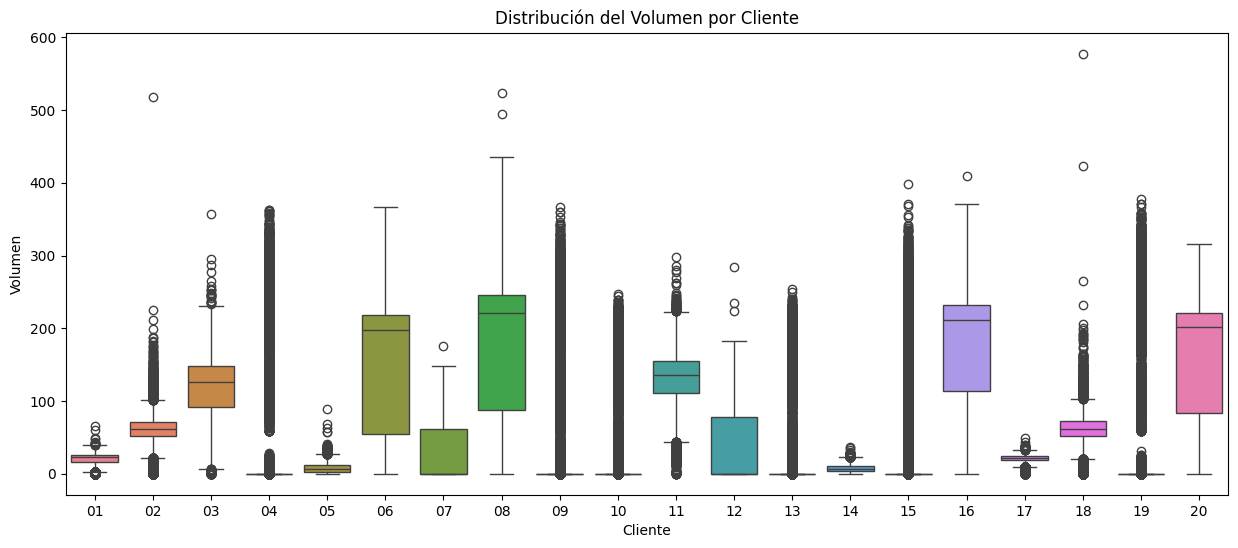

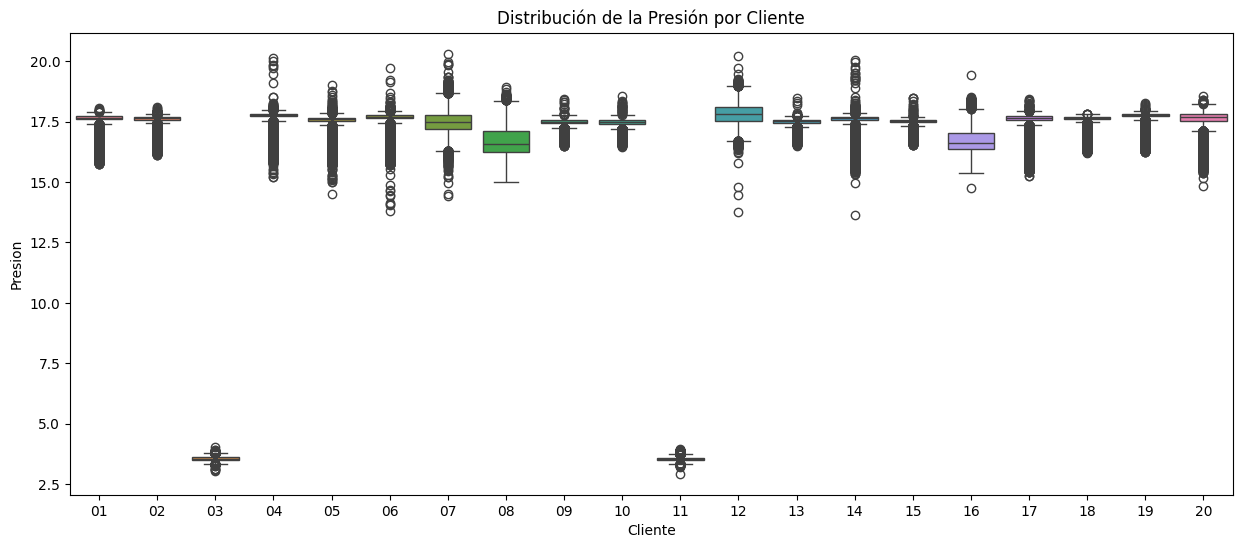

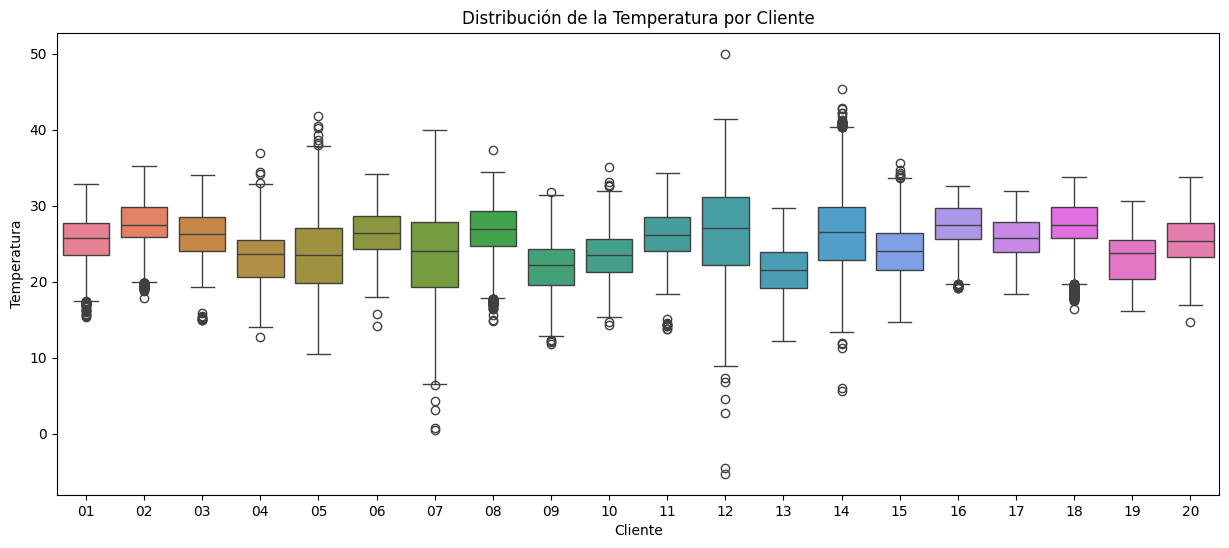

In [25]:
# Boxplot para Volumen por cliente
plt.figure(figsize=(15, 6))
sns.boxplot(x='Cliente', y='Volumen', data=df, palette='husl', hue='Cliente')
plt.title('Distribución del Volumen por Cliente')
plt.show()

# Boxplot para Presión por cliente
plt.figure(figsize=(15, 6))
sns.boxplot(x='Cliente', y='Presion', data=df, palette='husl', hue='Cliente')
plt.title('Distribución de la Presión por Cliente')
plt.show()

# Boxplot para Temperatura por cliente
plt.figure(figsize=(15, 6))
sns.boxplot(x='Cliente', y='Temperatura', data=df, palette='husl', hue='Cliente')
plt.title('Distribución de la Temperatura por Cliente')
plt.show()


In [12]:
variables = ['Presion', 'Temperatura', 'Volumen']

for var in variables:
    print(f"\nEstadísticas descriptivas para {var} por cliente:")
    resumen_df = df.groupby('Cliente')[var].describe()
    display(resumen_df.style.format("{:.2f}").set_caption(f"Estadísticas descriptivas para {var}"))


Estadísticas descriptivas para Presion por cliente:


C:\Users\evaka\AppData\Local\Temp\ipykernel_17612\848565815.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_df = df.groupby('Cliente')[var].describe()



Estadísticas descriptivas para Temperatura por cliente:


C:\Users\evaka\AppData\Local\Temp\ipykernel_17612\848565815.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_df = df.groupby('Cliente')[var].describe()



Estadísticas descriptivas para Volumen por cliente:


C:\Users\evaka\AppData\Local\Temp\ipykernel_17612\848565815.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_df = df.groupby('Cliente')[var].describe()


In [16]:
def calcular_anomalias_por_cliente(df, variables):
    resultados = []
    for variable in variables:
        for cliente in df['Cliente'].unique():
            df_cliente = df[df['Cliente'] == cliente]
            q1 = df_cliente[variable].quantile(0.01)
            q99 = df_cliente[variable].quantile(0.99)
            for year in df_cliente['Año'].unique():
                df_cliente_anio = df_cliente[df_cliente['Año'] == year]
                total_registros = len(df_cliente_anio)
                anomalias = df_cliente_anio[
                    (df_cliente_anio[variable] < q1) | (df_cliente_anio[variable] > q99)
                ]
                total_anomalias = len(anomalias)
                porcentaje_anomalias = (total_anomalias / total_registros) * 100
                resultados.append({
                    'Cliente': cliente,
                    'Variable': variable,
                    'Año': year,
                    'Total_Registros': total_registros,
                    'Total_Anomalias': total_anomalias,
                    '%_Anomalias': round(porcentaje_anomalias, 2)
                })
    return pd.DataFrame(resultados)

# Variables a analizar
variables = ['Presion', 'Temperatura', 'Volumen']

# Calcular las anomalías
tabla_anomalias = calcular_anomalias_por_cliente(df, variables)
tabla_anomalias


Cliente Variable   Año  Total_Registros  Total_Anomalias  %_Anomalias
0        01  Presion  2019             8444                4         0.05
1        01  Presion  2020             8780                3         0.03
2        01  Presion  2021             8683              377         4.34
3        01  Presion  2022             8749               44         0.50
4        01  Presion  2023             8756              442         5.05
..      ...      ...   ...              ...              ...          ...
295      20  Volumen  2019             8197               35         0.43
296      20  Volumen  2020             8758               84         0.96
297      20  Volumen  2021             8652               64         0.74
298      20  Volumen  2022             8525               94         1.10
299      20  Volumen  2023             8676              152         1.75

[300 rows x 6 columns]

In [20]:
#5 clientes con mayor porcentaje de anomalías por año y variable
def top_clientes_por_anomalias(tabla_anomalias, top_n=5):
    tabla_anomalias_ordenada = tabla_anomalias.sort_values(
        by=['Año', 'Variable', '%_Anomalias'], ascending=[True, True, False]
    )
    
    #top_n
    top_clientes = (
        tabla_anomalias_ordenada.groupby(['Año', 'Variable'])
        .head(top_n)
        .reset_index(drop=True)
    )
    
    return top_clientes

top_clientes = top_clientes_por_anomalias(tabla_anomalias, top_n=5)
pd.set_option('display.max_rows', None)

# Mostrar el DataFrame completo
print(top_clientes)


   Cliente     Variable   Año  Total_Registros  Total_Anomalias  %_Anomalias
0       06      Presion  2019             8197              137         1.67
1       10      Presion  2019             8177              127         1.55
2       15      Presion  2019             8183              118         1.44
3       20      Presion  2019             8197              118         1.44
4       18      Presion  2019             7027               62         0.88
5       02  Temperatura  2019             7027              445         6.33
6       18  Temperatura  2019             7027              432         6.15
7       01  Temperatura  2019             8444              302         3.58
8       09  Temperatura  2019             8183              292         3.57
9       03  Temperatura  2019             8174              280         3.43
10      16      Volumen  2019             8297              444         5.35
11      08      Volumen  2019             8297              379         4.57

La claridad de los datos está asegurada por la consistencia en sus unidades de medición y el etiquetado de las variables. Las unidades empleadas —grados Celsius, bar y metros cúbicos— cumplen con los estándares requeridos para el monitoreo del gas, eliminando la necesidad de realizar transformaciones adicionales. Además, los datos presentan un formato estructurado, con las fechas en formato datetime64 y las variables numéricas como float, facilitando tanto el análisis como las transformaciones requeridas para modelar series temporales. 

## 2. Técnicas de Limpieza de Datos

### 2.1 Imputación de Valores Faltantes

Paso 1: Serie temporal completa y detectar valores faltantes
El objetivo de este paso es asegurarnos de que los datos de cada cliente tengan un rango temporal continuo desde el 2019-01-14 00:00:00 hasta el 2023-12-31 23:00:00 (registros cada hora). Esto nos permitirá identificar valores faltantes para cada cliente, interpolarlos y agregar una columna que identifique fallas en el sensor.

In [77]:
# 1. Rango completo de fechas desde 2019-01-14 00:00:00 hasta 2023-12-31 23:00:00
rango_fechas = pd.date_range(start="2019-01-14 00:00:00", end="2023-12-31 23:00:00", freq="H")

# 2. DataFrame vacío con este rango de fechas
serie_temporal_completa = pd.DataFrame({"Fecha": rango_fechas})

C:\Users\elixa\AppData\Local\Temp\ipykernel_36672\1610175932.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rango_fechas = pd.date_range(start="2019-01-14 00:00:00", end="2023-12-31 23:00:00", freq="H")


In [78]:
# 3. Iterar sobre cada cliente y completar los datos faltantes

clientes_unicos = df["Cliente"].unique()  # Obtener la lista de clientes únicos
resultados = []

In [79]:
for cliente in clientes_unicos:
    # Filtrar los datos para el cliente actual
    df_cliente = df[df["Cliente"] == cliente].copy()
    
    # Asegurarnos de que no se pierda la columna 'Cliente'
    df_cliente["Cliente"] = cliente
    
    # Combinar la serie temporal completa con los datos del cliente
    df_cliente_completo = pd.merge(
        serie_temporal_completa, 
        df_cliente, 
        on="Fecha", 
        how="left"  # Mantener todas las fechas del rango completo
    )
    
    # Rellenar la columna 'Cliente' con el ID del cliente
    df_cliente_completo["Cliente"] = cliente
    
    # Agregar la columna de errores del sensor
    df_cliente_completo["Sensor_Error"] = np.where(
        df_cliente_completo["Presion"].isnull(), 1, 0
    )
    
    # Interpolar los valores faltantes para las columnas numéricas
    for columna in ["Presion", "Temperatura", "Volumen"]:
        df_cliente_completo[columna] = df_cliente_completo[columna].interpolate(method="linear")
    
    # Añadir el DataFrame del cliente actual a la lista de resultados
    resultados.append(df_cliente_completo)

In [80]:
#4. Combinamos los resultados
df_limpieza1 = pd.concat(resultados)

In [81]:
#5. Ordenamos por clientey Fecha
df_limpieza1 = df_limpieza1.sort_values(by=["Cliente", "Fecha"]).reset_index(drop=True)

C:\Users\elixa\AppData\Local\Temp\ipykernel_36672\155059490.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


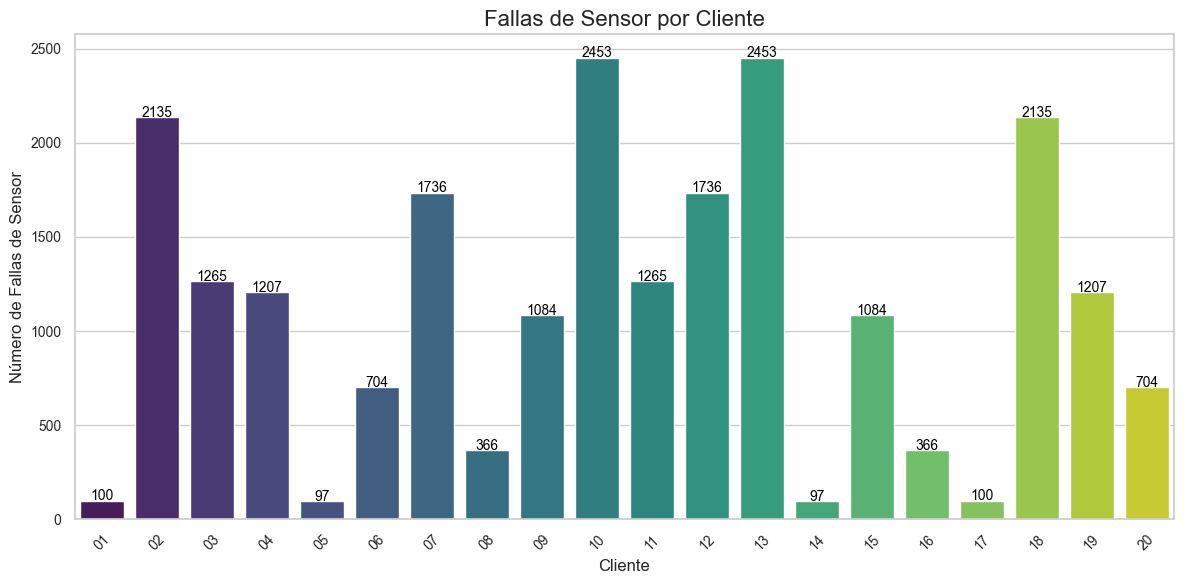

In [82]:
# Contar fallas de sensor por cliente
fallas_sensor = df_limpieza1.groupby("Cliente")["Sensor_Error"].sum().reset_index()

# Ordenar por cliente en orden ascendente
fallas_sensor = fallas_sensor.sort_values(by="Cliente", ascending=True)

# Configurar el estilo de la gráfica
sns.set_theme(style="whitegrid", palette="muted")

# Crear la gráfica
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x="Cliente", 
    y="Sensor_Error", 
    data=fallas_sensor, 
    palette="viridis"
)

# Añadir los números de fallas sobre cada barra
for i, row in fallas_sensor.iterrows():
    ax.text(
        i,  # Posición en el eje X
        row["Sensor_Error"] + 1,  # Posición en el eje Y (ligeramente arriba de la barra)
        int(row["Sensor_Error"]),  # Valor a mostrar
        color="black", 
        ha="center", 
        fontsize=10
    )

# Personalizar el diseño
plt.title("Fallas de Sensor por Cliente", fontsize=16)
plt.xlabel("Cliente", fontsize=12)
plt.ylabel("Número de Fallas de Sensor", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Guardar la gráfica como imagen
plt.savefig("fallas_sensor_por_cliente.png", dpi=300, bbox_inches="tight")

# Mostrar la gráfica
plt.show()


In [83]:
df_limpieza1

Fecha    Presion  Temperatura     Volumen Cliente  \
0      2019-01-14 00:00:00  17.732563    28.209354   20.969751      01   
1      2019-01-14 01:00:00  17.747776    28.518614   17.845739      01   
2      2019-01-14 02:00:00  17.758916    28.230191   20.975914      01   
3      2019-01-14 03:00:00  17.727940    27.811509   20.592299      01   
4      2019-01-14 04:00:00  17.746484    27.795293   21.690626      01   
...                    ...        ...          ...         ...     ...   
870249 2023-12-31 19:00:00  15.751139    27.460652  204.457549      20   
870250 2023-12-31 20:00:00  15.614858    27.010382  186.512096      20   
870251 2023-12-31 21:00:00  15.598944    26.709100  204.456461      20   
870252 2023-12-31 22:00:00  15.730040    27.266090  203.695596      20   
870253 2023-12-31 23:00:00  15.624457    27.481288  201.534548      20   

           Año  Sensor_Error  
0       2019.0             0  
1       2019.0             0  
2       2019.0             0  
3       2019.0             0  
4       2019.0             0  
...        ...           ...  
870249  2023.0             0  
870250  2023.0             0  
870251  2023.0             0  
870252  2023.0             0  
870253  2023.0             0  

[870254 rows x 7 columns]

### 2.2 Eliminación de Duplicados

Duplicados Exactos: Verificaremos si todas las columnas tienen registros idénticos para un mismo cliente.

In [84]:
# Identificar duplicados exactos
duplicados_por_cliente = (
    df_limpieza1[df_limpieza1.duplicated(keep=False)]
    .groupby("Cliente")
    .size()
    .reset_index(name="Duplicados_Exactos")
)

# Eliminar duplicados exactos
df_limpieza2 = df_limpieza1.drop_duplicates()

# Calcular registros eliminados
duplicados_eliminados_total = len(df_limpieza1) - len(df_limpieza2)
print(f"Número total de registros eliminados por ser duplicados exactos: {duplicados_eliminados_total}")

# Mostrar cantidad de duplicados eliminados por cliente
duplicados_por_cliente = duplicados_por_cliente.sort_values(by="Cliente")
print(duplicados_por_cliente)



Número total de registros eliminados por ser duplicados exactos: 0
Empty DataFrame
Columns: [Cliente, Duplicados_Exactos]
Index: []


In [85]:
# Paso 2: Identificar fechas duplicadas con diferentes valores de medición
# Agrupar por Cliente y Fecha, contar registros y verificar si hay más de uno
df_limpieza3 = df_limpieza2.copy()
df_limpieza3["Double_Reading"] = df_limpieza3.duplicated(subset=["Cliente", "Fecha"], keep=False).astype(int)

# Imprimir resumen de las dobles lecturas
num_dobles = df_limpieza3["Double_Reading"].sum()
print(f"Se detectaron {num_dobles} dobles lecturas en el conjunto de datos.")


Se detectaron 28 dobles lecturas en el conjunto de datos.


C:\Users\elixa\AppData\Local\Temp\ipykernel_36672\4168678162.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


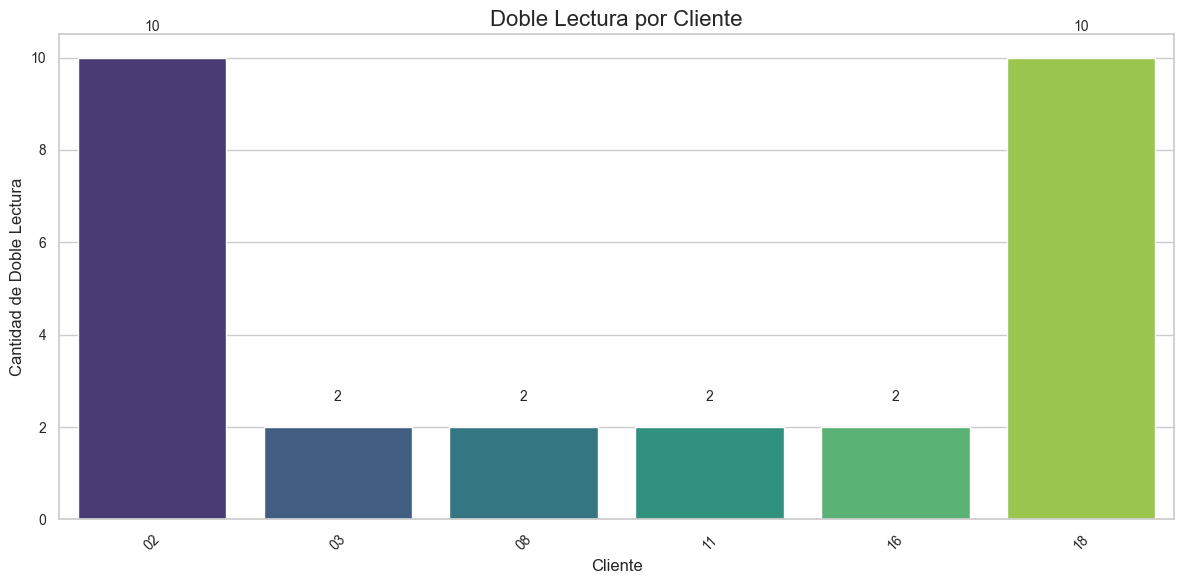

In [86]:
# Contar duplicados por cliente y fecha (Double_Reading = 1)
dobles_lecturas_por_cliente = (
    df_limpieza3[df_limpieza3["Double_Reading"] == 1]
    .groupby("Cliente")["Double_Reading"]
    .count()
    .reset_index()
    .rename(columns={"Double_Reading": "Cantidad_Dobles"})
)

# Ordenar clientes en ascendente
dobles_lecturas_por_cliente = dobles_lecturas_por_cliente.sort_values(by="Cliente")

# Configurar el estilo de la gráfica
sns.set_theme(style="whitegrid", palette="muted")

# Crear la gráfica
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x="Cliente", 
    y="Cantidad_Dobles", 
    data=dobles_lecturas_por_cliente, 
    palette="viridis"
)

# Agregar valores sobre las barras
for index, row in dobles_lecturas_por_cliente.iterrows():
    ax.text(
        row.name, 
        row.Cantidad_Dobles + 0.5,  # Ajuste para que el número quede sobre la barra
        f"{int(row.Cantidad_Dobles)}", 
        ha="center", 
        va="bottom", 
        fontsize=10
    )

# Configurar títulos y ejes
plt.title("Doble Lectura por Cliente", fontsize=16)
plt.xlabel("Cliente", fontsize=12)
plt.ylabel("Cantidad de Doble Lectura", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Guardar la gráfica como imagen
plt.savefig("doble_lectura_por_cliente.png", dpi=300, bbox_inches="tight")

# Mostrar la gráfica
plt.show()


### 2.3 Verificación de Nulos por Variable

In [87]:
# Inicializamos un DataFrame para almacenar los resultados finales después del paso 3
resultados_nulos = []

# Iterar por cliente
for cliente in df_limpieza3["Cliente"].unique():
    # Filtrar datos por cliente
    df_cliente = df_limpieza2[df_limpieza2["Cliente"] == cliente].copy()
    
    # Verificar nulos por variable
    nulos_presion = df_cliente["Presion"].isnull().sum()
    nulos_temperatura = df_cliente["Temperatura"].isnull().sum()
    nulos_volumen = df_cliente["Volumen"].isnull().sum()
    
    print(f"Cliente {cliente}:")
    print(f"  Nulos en Presión: {nulos_presion}")
    print(f"  Nulos en Temperatura: {nulos_temperatura}")
    print(f"  Nulos en Volumen: {nulos_volumen}")
    
    # Crear columna 'Error_Lectura' para marcar nulos originales
    df_cliente["Error_Lectura"] = df_cliente[["Presion", "Temperatura", "Volumen"]].isnull().any(axis=1).astype(int)
    
    # Interpolar valores nulos linealmente
    df_cliente["Presion"] = df_cliente["Presion"].interpolate(method="linear")
    df_cliente["Temperatura"] = df_cliente["Temperatura"].interpolate(method="linear")
    df_cliente["Volumen"] = df_cliente["Volumen"].interpolate(method="linear")
    
    # Agregar cliente al resultado final
    resultados_nulos.append(df_cliente)

# Combinar resultados de todos los clientes
df_limpieza4 = pd.concat(resultados_nulos)

# Ordenar por cliente y fecha
df_limpieza4 = df_limpieza3.sort_values(by=["Cliente", "Fecha"]).reset_index(drop=True)

# Guardar el resultado
print(f"Registros totales después de tratar nulos: {len(df_limpieza3)}")


Cliente 01:
  Nulos en Presión: 0
  Nulos en Temperatura: 0
  Nulos en Volumen: 0
Cliente 02:
  Nulos en Presión: 0
  Nulos en Temperatura: 0
  Nulos en Volumen: 0
Cliente 03:
  Nulos en Presión: 0
  Nulos en Temperatura: 0
  Nulos en Volumen: 0
Cliente 04:
  Nulos en Presión: 0
  Nulos en Temperatura: 0
  Nulos en Volumen: 0
Cliente 05:
  Nulos en Presión: 0
  Nulos en Temperatura: 0
  Nulos en Volumen: 0
Cliente 06:
  Nulos en Presión: 0
  Nulos en Temperatura: 0
  Nulos en Volumen: 0
Cliente 07:
  Nulos en Presión: 0
  Nulos en Temperatura: 0
  Nulos en Volumen: 0
Cliente 08:
  Nulos en Presión: 0
  Nulos en Temperatura: 0
  Nulos en Volumen: 0
Cliente 09:
  Nulos en Presión: 0
  Nulos en Temperatura: 0
  Nulos en Volumen: 0
Cliente 10:
  Nulos en Presión: 0
  Nulos en Temperatura: 0
  Nulos en Volumen: 0
Cliente 11:
  Nulos en Presión: 0
  Nulos en Temperatura: 0
  Nulos en Volumen: 0
Cliente 12:
  Nulos en Presión: 0
  Nulos en Temperatura: 0
  Nulos en Volumen: 0
Cliente 13:
  Nu

## 3. Procesos de entendimiento de los datos 

### 3.1 Generación de variables temporales

In [88]:
# Vamos a agregar variables temporales para ayudar al modelo

df_limpieza5 = df_limpieza4.copy()

# Generamos las variables temporales
df_limpieza5["Año"] = df_limpieza5["Fecha"].dt.year
df_limpieza5["Mes"] = df_limpieza5["Fecha"].dt.month
df_limpieza5["Día"] = df_limpieza5["Fecha"].dt.day
df_limpieza5["Hora"] = df_limpieza5["Fecha"].dt.hour
df_limpieza5["Día_Semana"] = df_limpieza5["Fecha"].dt.dayofweek  # 0=Lunes, 6=Domingo
df_limpieza5["Fin_de_Semana"] = df_limpieza5["Día_Semana"].apply(lambda x: 1 if x >= 5 else 0)

# Verificamos el resultado
print(df_limpieza5.head())

# Guardar en un archivo limpio para futuros pasos
df_limpieza5.to_csv("df_limpieza5.csv", index=False)

                Fecha    Presion  Temperatura    Volumen Cliente   Año  \
0 2019-01-14 00:00:00  17.732563    28.209354  20.969751      01  2019   
1 2019-01-14 01:00:00  17.747776    28.518614  17.845739      01  2019   
2 2019-01-14 02:00:00  17.758916    28.230191  20.975914      01  2019   
3 2019-01-14 03:00:00  17.727940    27.811509  20.592299      01  2019   
4 2019-01-14 04:00:00  17.746484    27.795293  21.690626      01  2019   

   Sensor_Error  Double_Reading  Mes  Día  Hora  Día_Semana  Fin_de_Semana  
0             0               0    1   14     0           0              0  
1             0               0    1   14     1           0              0  
2             0               0    1   14     2           0              0  
3             0               0    1   14     3           0              0  
4             0               0    1   14     4           0              0  


In [89]:
df_limpieza5

Fecha    Presion  Temperatura     Volumen Cliente   Año  \
0      2019-01-14 00:00:00  17.732563    28.209354   20.969751      01  2019   
1      2019-01-14 01:00:00  17.747776    28.518614   17.845739      01  2019   
2      2019-01-14 02:00:00  17.758916    28.230191   20.975914      01  2019   
3      2019-01-14 03:00:00  17.727940    27.811509   20.592299      01  2019   
4      2019-01-14 04:00:00  17.746484    27.795293   21.690626      01  2019   
...                    ...        ...          ...         ...     ...   ...   
870249 2023-12-31 19:00:00  15.751139    27.460652  204.457549      20  2023   
870250 2023-12-31 20:00:00  15.614858    27.010382  186.512096      20  2023   
870251 2023-12-31 21:00:00  15.598944    26.709100  204.456461      20  2023   
870252 2023-12-31 22:00:00  15.730040    27.266090  203.695596      20  2023   
870253 2023-12-31 23:00:00  15.624457    27.481288  201.534548      20  2023   

        Sensor_Error  Double_Reading  Mes  Día  Hora  Día_Semana  \
0                  0               0    1   14     0           0   
1                  0               0    1   14     1           0   
2                  0               0    1   14     2           0   
3                  0               0    1   14     3           0   
4                  0               0    1   14     4           0   
...              ...             ...  ...  ...   ...         ...   
870249             0               0   12   31    19           6   
870250             0               0   12   31    20           6   
870251             0               0   12   31    21           6   
870252             0               0   12   31    22           6   
870253             0               0   12   31    23           6   

        Fin_de_Semana  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
870249              1  
870250              1  
870251              1  
870252              1  
870253              1  

[870254 rows x 13 columns]

### 3.2 Escalado de los datos

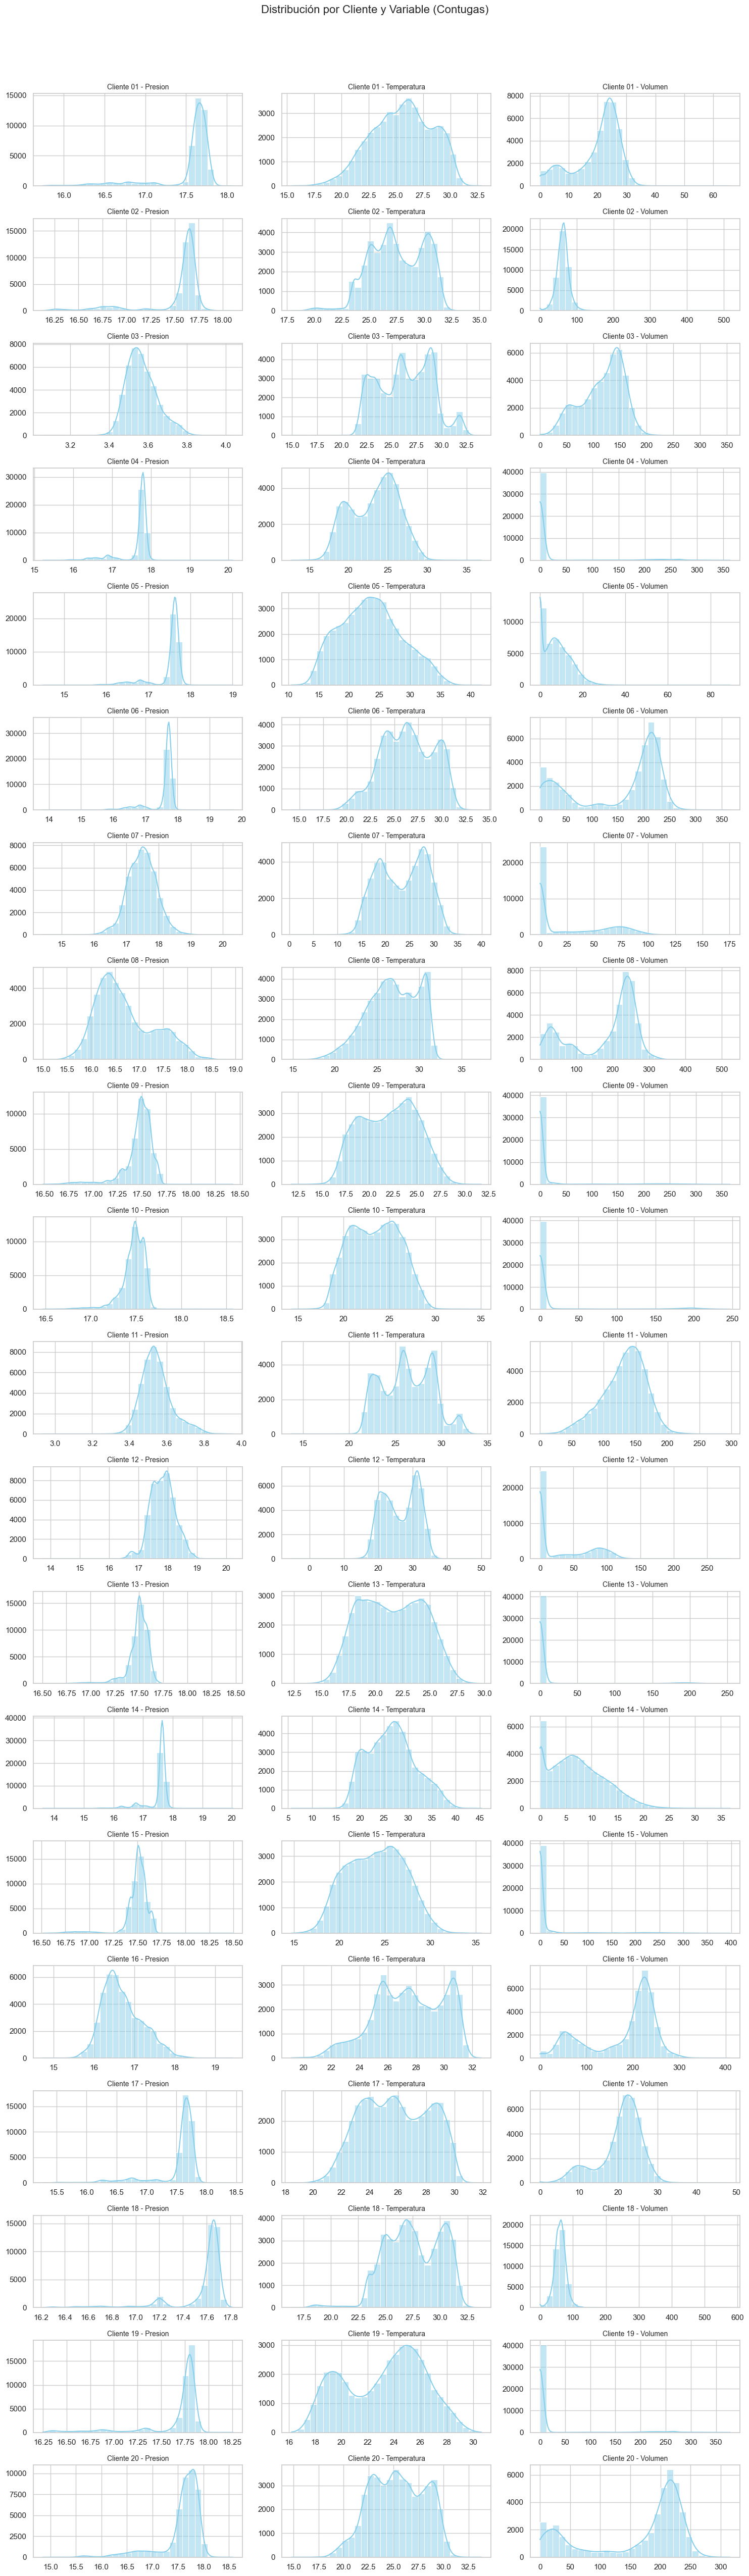

In [91]:
#1. Vamos a verificar si los datos siguen una distribucion normal

# Variables a analizar
variables = ["Presion", "Temperatura", "Volumen"]

# Clientes únicos
clientes_unicos = df_limpieza5["Cliente"].unique()

# Crear la figura de la grilla
fig, axes = plt.subplots(20, 3, figsize=(15, 50))  # 20 filas, 3 columnas para cada cliente y variable
fig.subplots_adjust(hspace=0.5)  # Ajustar el espacio entre los gráficos

# Iterar por cada cliente y variable para graficar
for i, cliente in enumerate(clientes_unicos):
    df_cliente = df_limpieza5[df_limpieza5["Cliente"] == cliente]
    
    for j, var in enumerate(variables):
        # Histograma
        sns.histplot(
            df_cliente[var], 
            kde=True, 
            bins=30, 
            ax=axes[i, j], 
            color="skyblue"
        )
        axes[i, j].set_title(f"Cliente {cliente} - {var}", fontsize=10)
        axes[i, j].set_xlabel("")
        axes[i, j].set_ylabel("")

# Títulos generales
fig.suptitle("Distribución por Cliente y Variable (Contugas)", fontsize=16, y=1.02)
plt.tight_layout()

# Guardar la grilla como imagen
plt.savefig("distribuciones_clientes.png", dpi=300, bbox_inches="tight")

# Mostrar la grilla
plt.show()

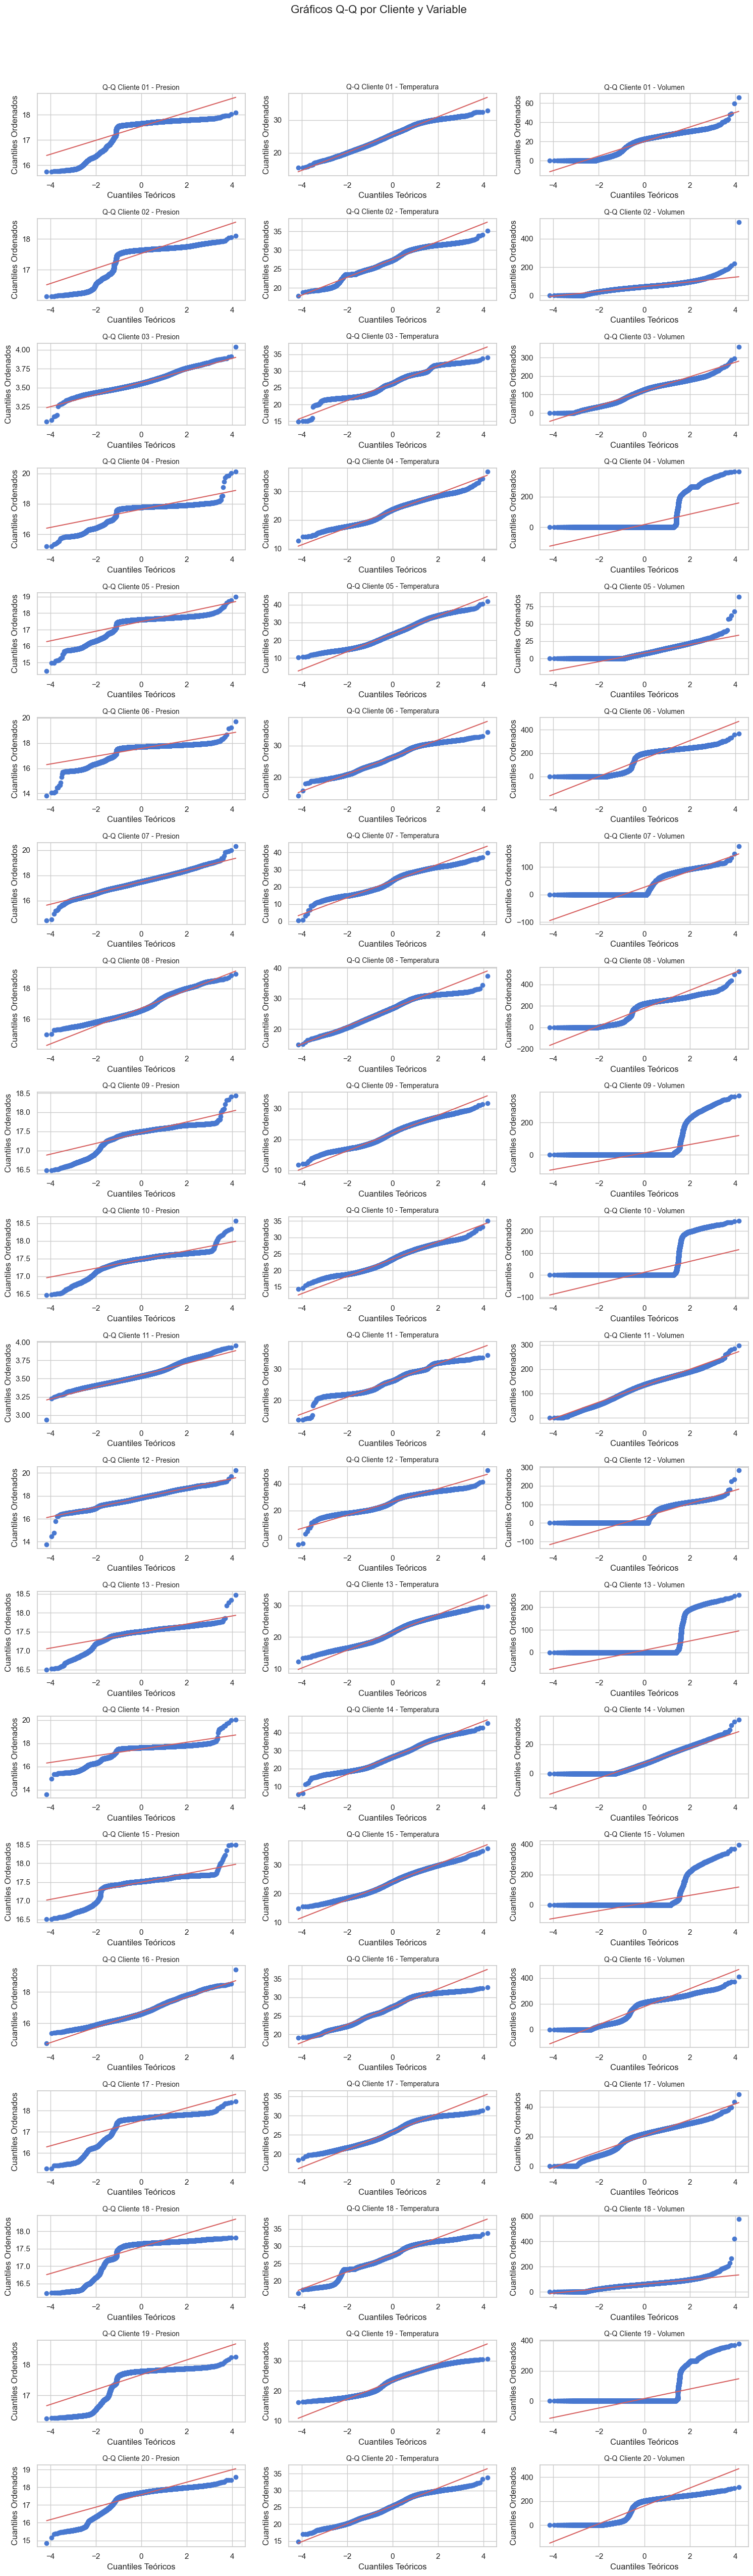

In [92]:
#Q-Qs para el informe

fig, axes = plt.subplots(20, 3, figsize=(15, 50))  
fig.subplots_adjust(hspace=0.5)  

for i, cliente in enumerate(clientes_unicos):
    df_cliente = df_limpieza5[df_limpieza5["Cliente"] == cliente]
    
    for j, var in enumerate(variables):
        # Gráfico Q-Q
        stats.probplot(df_cliente[var], dist="norm", plot=axes[i, j])
        axes[i, j].set_title(f"Q-Q Cliente {cliente} - {var}", fontsize=10)
        axes[i, j].set_xlabel("Cuantiles Teóricos")
        axes[i, j].set_ylabel("Cuantiles Ordenados")

# Títulos generales
fig.suptitle("Gráficos Q-Q por Cliente y Variable", fontsize=16, y=1.02)
plt.tight_layout()

# Guardar la grilla como imagen
plt.savefig("qq_graficos_clientes.png", dpi=300, bbox_inches="tight")

# Mostrar la grilla
plt.show()

In [ ]:
#Procedemos al proceso de estandarizacion 

from sklearn.preprocessing import StandardScaler

df_limpieza6 = df_limpieza5.copy()

# Variables a estandarizar
variables = ["Presion", "Temperatura", "Volumen"]

# Estandarización por cliente
clientes_unicos = df_limpieza6["Cliente"].unique()

for cliente in clientes_unicos:
    # Filtrar los datos para el cliente actual
    df_cliente = df_limpieza6[df_limpieza6["Cliente"] == cliente]
    
    # Inicializar el escalador
    scaler = StandardScaler()
    
    # Estandarizar solo las variables seleccionadas
    df_limpieza6.loc[df_limpieza6["Cliente"] == cliente, variables] = scaler.fit_transform(df_cliente[variables])





In [148]:
df_escalado = df_limpieza6.copy()

In [ ]:
# Guardar el DataFrame estandarizado
df_escalado.to_csv("df_escalado.csv", index=False)

In [ ]:
#DF contugas sin escalar
df_contugas = df_limpieza5.copy()

In [151]:
# Guardar el DataFrame final 
df_contugas.to_csv("df_contugas.csv", index=False)

### 3.3 Análisis del comportamiento de los ceros en Volumen

In [152]:
df_ceros = df_contugas.copy()

# Crear tabla resumen de ceros en Volumen
resumen_ceros_volumen = df_ceros.groupby("Cliente").agg(
    Ceros_Volumen=("Volumen", lambda x: (x == 0).sum()),  # Contar los ceros en Volumen
    Total_Registros=("Volumen", "count")  # Contar el total de registros por cliente
)

resumen_ceros_volumen["%Ceros_Volumen"] = (resumen_ceros_volumen["Ceros_Volumen"] / resumen_ceros_volumen["Total_Registros"]) * 100


# Mostrar la tabla
display(resumen_ceros_volumen)

Ceros_Volumen  Total_Registros  %Ceros_Volumen
Cliente                                                
01                 614            43512        1.411105
02                 141            43517        0.324011
03                  41            43513        0.094225
04               30676            43512       70.500092
05                7492            43512       17.218239
06                2071            43512        4.759607
07               23287            43512       53.518570
08                 840            43513        1.930458
09               38126            43512       87.621805
10               37708            43512       86.661151
11                   8            43513        0.018385
12               24555            43512       56.432708
13               37250            43512       85.608568
14                4240            43512        9.744438
15               37807            43512       86.888674
16                 390            43513        0.896284
17                  65            43512        0.149384
18                 184            43517        0.422823
19               33959            43512       78.045137
20                1257            43512        2.888858

In [153]:
# Crear una nueva columna para identificar cuando el Volumen es 0
df_ceros["Es_Cero"] = (df_ceros["Volumen"] == 0).astype(int)

display(df_ceros.head())


Fecha    Presion  Temperatura    Volumen Cliente   Año  \
0 2019-01-14 00:00:00  17.732563    28.209354  20.969751      01  2019   
1 2019-01-14 01:00:00  17.747776    28.518614  17.845739      01  2019   
2 2019-01-14 02:00:00  17.758916    28.230191  20.975914      01  2019   
3 2019-01-14 03:00:00  17.727940    27.811509  20.592299      01  2019   
4 2019-01-14 04:00:00  17.746484    27.795293  21.690626      01  2019   

   Sensor_Error  Double_Reading  Mes  Día  Hora  Día_Semana  Fin_de_Semana  \
0             0               0    1   14     0           0              0   
1             0               0    1   14     1           0              0   
2             0               0    1   14     2           0              0   
3             0               0    1   14     3           0              0   
4             0               0    1   14     4           0              0   

   Es_Cero  
0        0  
1        0  
2        0  
3        0  
4        0

In [154]:
# Crear la tabla de ceros por Cliente y Año
tabla_ceros_ano = df_ceros[df_ceros["Es_Cero"] == 1].groupby(["Cliente", "Año"])["Es_Cero"].sum().unstack(fill_value=0)

# Dividir por el número de años disponibles para obtener el promedio
promedios_ano = tabla_ceros_ano.mean(axis=1)

# Mostrar la tabla
display(tabla_ceros_ano)
print("\nPromedio por Año por Cliente:")
display(promedios_ano)


Año      2019  2020  2021  2022  2023
Cliente                              
01         29   369    26    20   170
02         34    30    15    21    41
03          6    22    11     2     0
04       5905  6071  6211  6216  6273
05       1994  2560  2074   699   165
06       1235   496   110   184    46
07       4997  5039  4984  4640  3627
08        140   382   209    54    55
09       7708  7361  7684  7656  7717
10       7118  7794  7715  7456  7625
11          0     0     7     0     1
12       5217  5599  5305  4718  3716
13       7657  7307  7430  7271  7585
14       1044  1888  1152   138    18
15       7489  7649  7479  7976  7214
16         64   205   110     5     6
17          0     0     0     3    62
18         40    44    28    24    48
19       6558  7046  6778  6902  6675
20        460   267   164   261   105


Promedio por Año por Cliente:


Cliente
01     122.8
02      28.2
03       8.2
04    6135.2
05    1498.4
06     414.2
07    4657.4
08     168.0
09    7625.2
10    7541.6
11       1.6
12    4911.0
13    7450.0
14     848.0
15    7561.4
16      78.0
17      13.0
18      36.8
19    6791.8
20     251.4
dtype: float64

In [157]:
# Filtrar solo los ceros en el Volumen
df_ceros_mes = df_ceros[df_ceros["Es_Cero"] == 1]

# Crear una tabla que cuente cuántos ceros hay por Cliente y Mes
ceros_por_mes = df_ceros_mes.groupby(["Cliente", "Mes"])["Es_Cero"].sum()

# Asegurarnos de que la columna Fecha solo contenga la parte del día
df_ceros["Fecha_Dia"] = df_ceros_mes["Fecha"].dt.date

# Contar cuántos meses únicos existen por Cliente y Mes
meses_unicos = df_ceros.groupby(["Cliente", "Mes"])["Fecha_Dia"].nunique()

# Calcular el promedio de ceros por mes
promedio_ceros_por_mes = ceros_por_mes / meses_unicos

# Formatear como tabla
promedio_ceros_por_mes = promedio_ceros_por_mes.unstack(fill_value=0)

# Mostrar la tabla
display(promedio_ceros_por_mes)

# Guardar la tabla como archivo CSV si deseas
promedio_ceros_por_mes.to_csv("promedio_ceros_por_mes.csv", index=True)



Mes             1          2          3          4          5          6   \
Cliente                                                                     
01        2.714286   1.142857   4.545455   8.583333   6.666667   2.500000   
02        1.000000   1.000000   1.058824   1.071429   1.000000   1.000000   
03        1.166667   1.125000   1.000000   1.000000   1.000000   1.000000   
04       17.737226  17.776978  17.353333  18.000000  18.080537  17.150685   
05        4.718750   5.039370   5.148148   5.114504   5.753968   5.492308   
06        3.369231   4.523810   5.049383   5.012658   1.303030   1.612903   
07             NaN        NaN  11.311111  22.033613  21.958333  23.240000   
08        1.100000   1.000000   1.187500   2.666667   1.457143   1.136364   
09       21.643939  21.074627  21.758170  22.006803  21.310811  22.550336   
10       21.237410  22.029851  21.543046  21.885714  22.607843  21.489796   
11        1.000000   1.000000   1.000000   1.000000        NaN   1.000000   
12        1.000000   1.000000  20.276923  23.783333  23.253425  23.773333   
13       20.608696  21.942857  20.935484  21.546667  21.059211  21.130137   
14        3.281250   2.970874   3.971963   3.904762   4.233645   4.592233   
15       21.485714  21.124088  21.934211  21.598639  21.701299  21.048611   
16        1.000000   1.000000        NaN   2.333333   2.250000   1.000000   
17             NaN        NaN   1.000000   1.000000        NaN   1.000000   
18        1.055556   1.083333   1.062500   1.166667   1.050000   1.090909   
19       19.706767  18.926471  19.163265  19.972414  19.851351  19.602740   
20        1.390244   3.019608   1.380000   2.929825   1.266667   1.294118   

Mes             7          8          9          10         11         12  
Cliente                                                                    
01        5.384615   4.384615   1.200000   1.000000   1.000000   1.555556  
02        1.000000   1.000000   1.125000   1.000000   1.000000   1.214286  
03        1.000000        NaN   1.000000        NaN        NaN   1.000000  
04       17.765517  17.370629  17.537415  17.691781  17.903448  17.340000  
05        5.143939   4.854839   5.043860   4.794643   5.009259   4.250000  
06        1.586957   2.142857   1.984375   1.738462   1.818182   1.352941  
07       23.193548  23.329032  23.273333  21.569231   1.000000        NaN  
08        1.458333   2.724138   4.265306   3.204082   1.615385   2.608696  
09       22.098039  22.340136  22.333333  22.045752  21.978873  21.219858  
10       21.267123  21.527027  22.162963  22.260274  21.462069  21.350993  
11             NaN        NaN        NaN        NaN        NaN        NaN  
12       23.800000  23.819355  23.590604  22.309735   1.000000        NaN  
13       21.717241  21.413043  21.492754  21.474026  21.091549  21.046053  
14        4.081633   3.505263   3.659341   2.967391   3.126437   2.744444  
15       21.859060  21.731544  21.391608  22.331126  21.156028  21.328767  
16        1.000000   3.521739   5.266667   2.916667   1.000000   2.111111  
17        9.000000   8.500000        NaN        NaN        NaN        NaN  
18        1.000000   1.000000   1.111111   1.066667   1.111111   1.047619  
19       18.797297  19.097222  19.165517  20.120805  19.761905  19.720779  
20        1.966667   2.236842   2.159420   1.966102   1.791667   1.816327

In [156]:
# Filtrar solo los ceros en el Volumen
df_ceros_dia = df_ceros[df_ceros["Es_Cero"] == 1]

# Crear una tabla que cuente cuántos ceros hay por Cliente y Día de la Semana
ceros_por_dia_semana = df_ceros_dia.groupby(["Cliente", "Día_Semana"])["Es_Cero"].sum()

# Asegurarnos de que la columna Fecha solo contenga la parte del día
df_ceros["Fecha_Dia"] = df_ceros_dia["Fecha"].dt.date

# Contar cuántos días únicos de cada día de la semana existen por Cliente
dias_semana_unicos = df_ceros.groupby(["Cliente", "Día_Semana"])["Fecha_Dia"].nunique()

# Calcular el promedio de ceros por día de la semana
promedio_ceros_por_dia_semana = ceros_por_dia_semana / dias_semana_unicos

# Formatear como tabla
promedio_ceros_por_dia_semana = promedio_ceros_por_dia_semana.unstack(fill_value=0)

# Mostrar la tabla
display(promedio_ceros_por_dia_semana)

# Guardar la tabla como archivo CSV si deseas
promedio_ceros_por_dia_semana.to_csv("promedio_ceros_por_dia_semana.csv", index=True)

Día_Semana          0          1          2          3          4          5  \
Cliente                                                                        
01           4.194444   3.068182   9.200000   1.875000        NaN        NaN   
02           1.111111   1.000000   1.062500   1.000000   1.157895   1.000000   
03           1.000000   1.000000   1.000000   1.166667   1.250000   1.000000   
04          17.449799  17.813765  17.670683  18.051587  17.750000  17.471774   
05           4.854460   5.228155   4.990991   4.832579   5.156098   5.061033   
06           3.105263   3.232323   2.600000   3.204301   3.050505   3.000000   
07          21.784314  22.295302  22.395973  21.940397  22.293333  22.288591   
08           2.120690   2.266667   2.861111   2.871795   2.521739   2.278689   
09          21.888000  22.250000  21.988000  22.085020  21.630952  21.340000   
10          21.773279  21.568548  22.044534  21.384615  21.612000  21.851406   
11           1.000000        NaN   1.000000   1.000000        NaN        NaN   
12          23.218543  23.554054  22.947020  23.373333  22.915033  22.954545   
13          20.911647  21.177419  20.803922  21.725100  21.445783  21.420000   
14           3.573099   3.473373   3.809524   3.825581   3.402439   3.582822   
15          20.912000  21.448000  21.480315  21.734127  21.627530  21.880952   
16           3.200000   3.333333   3.588235   3.277778   2.666667   2.850000   
17                NaN        NaN        NaN   5.000000   8.400000        NaN   
18           1.090909   1.125000   1.043478   1.000000   1.052632   1.076923   
19          19.424490  19.543651  19.837302  19.588933  19.308000  19.194332   
20           2.190476   2.171429   1.777778   2.000000   2.000000   1.940299   

Día_Semana          6  
Cliente                
01           2.444444  
02           1.000000  
03           1.000000  
04          17.264228  
05           5.169082  
06           2.907216  
07          22.261745  
08           2.416667  
09          21.943089  
10          21.902834  
11           1.000000  
12          23.516556  
13          21.524194  
14           3.604790  
15          21.887097  
16           3.470588  
17           3.000000  
18           1.064516  
19          19.555556  
20           1.972973

### 3.3 Correlacion entre variables

In [179]:
correlaciones = df_contugas.groupby("Cliente")[["Presion", "Temperatura", "Volumen"]].corr()
correlaciones

Presion  Temperatura   Volumen
Cliente                                             
01      Presion      1.000000    -0.048116 -0.001692
        Temperatura -0.048116     1.000000  0.280204
        Volumen     -0.001692     0.280204  1.000000
02      Presion      1.000000     0.045631  0.023266
        Temperatura  0.045631     1.000000 -0.063017
        Volumen      0.023266    -0.063017  1.000000
03      Presion      1.000000     0.083750 -0.580610
        Temperatura  0.083750     1.000000 -0.132378
        Volumen     -0.580610    -0.132378  1.000000
04      Presion      1.000000    -0.079529  0.009921
        Temperatura -0.079529     1.000000 -0.022111
        Volumen      0.009921    -0.022111  1.000000
05      Presion      1.000000    -0.093850 -0.382174
        Temperatura -0.093850     1.000000  0.366654
        Volumen     -0.382174     0.366654  1.000000
06      Presion      1.000000    -0.024051 -0.174497
        Temperatura -0.024051     1.000000  0.337710
        Volumen     -0.174497     0.337710  1.000000
07      Presion      1.000000    -0.392742 -0.352319
        Temperatura -0.392742     1.000000  0.737958
        Volumen     -0.352319     0.737958  1.000000
08      Presion      1.000000    -0.497239 -0.881528
        Temperatura -0.497239     1.000000  0.525511
        Volumen     -0.881528     0.525511  1.000000
09      Presion      1.000000     0.020122 -0.689168
        Temperatura  0.020122     1.000000  0.060823
        Volumen     -0.689168     0.060823  1.000000
10      Presion      1.000000     0.172722 -0.512762
        Temperatura  0.172722     1.000000 -0.048329
        Volumen     -0.512762    -0.048329  1.000000
11      Presion      1.000000     0.125028 -0.608504
        Temperatura  0.125028     1.000000 -0.133159
        Volumen     -0.608504    -0.133159  1.000000
12      Presion      1.000000    -0.361469 -0.357434
        Temperatura -0.361469     1.000000  0.776259
        Volumen     -0.357434     0.776259  1.000000
13      Presion      1.000000     0.223393 -0.556157
        Temperatura  0.223393     1.000000 -0.047775
        Volumen     -0.556157    -0.047775  1.000000
14      Presion      1.000000    -0.100195 -0.446966
        Temperatura -0.100195     1.000000  0.299876
        Volumen     -0.446966     0.299876  1.000000
15      Presion      1.000000     0.050619 -0.768521
        Temperatura  0.050619     1.000000  0.003734
        Volumen     -0.768521     0.003734  1.000000
16      Presion      1.000000    -0.445641 -0.828224
        Temperatura -0.445641     1.000000  0.531071
        Volumen     -0.828224     0.531071  1.000000
17      Presion      1.000000     0.007945  0.012519
        Temperatura  0.007945     1.000000  0.121554
        Volumen      0.012519     0.121554  1.000000
18      Presion      1.000000     0.017376  0.010539
        Temperatura  0.017376     1.000000  0.010638
        Volumen      0.010539     0.010638  1.000000
19      Presion      1.000000    -0.085329 -0.024407
        Temperatura -0.085329     1.000000  0.015984
        Volumen     -0.024407     0.015984  1.000000
20      Presion      1.000000     0.002981 -0.054582
        Temperatura  0.002981     1.000000  0.359447
        Volumen     -0.054582     0.359447  1.000000

In [178]:


# Calcular la correlación entre las variables por cliente
correlaciones = df_contugas.groupby("Cliente")[["Presion", "Temperatura", "Volumen"]].corr().unstack()

# Definir umbral para considerar alta correlación
umbral = -0.8

# Crear un DataFrame que contenga las correlaciones altas
correlaciones_altas = correlaciones[(correlaciones < umbral) & (correlaciones < 1)]

# Filtrar para mostrar solo las correlaciones significativas, eliminando los valores de correlación consigo misma
correlaciones_altas = correlaciones_altas.dropna(how="all")

# Mostrar el resultado
correlaciones_altas



Presion                       Temperatura                      \
        Presion Temperatura   Volumen     Presion Temperatura Volumen   
Cliente                                                                 
08          NaN         NaN -0.881528         NaN         NaN     NaN   
16          NaN         NaN -0.828224         NaN         NaN     NaN   

          Volumen                      
          Presion Temperatura Volumen  
Cliente                                
08      -0.881528         NaN     NaN  
16      -0.828224         NaN     NaN

### 3.4 Caracteristicas Descriptivas

In [183]:
# Calcular métricas básicas por cliente
metricas_basicas = df_contugas.groupby("Cliente").agg(
    Media_Presion=("Presion", "mean"),
    Mediana_Presion=("Presion", "median"),
    Min_Presion=("Presion", "min"),
    Max_Presion=("Presion", "max"),
    Std_Presion=("Presion", "std"),
    Media_Temperatura=("Temperatura", "mean"),
    Mediana_Temperatura=("Temperatura", "median"),
    Min_Temperatura=("Temperatura", "min"),
    Max_Temperatura=("Temperatura", "max"),
    Std_Temperatura=("Temperatura", "std"),
    Media_Volumen=("Volumen", "mean"),
    Mediana_Volumen=("Volumen", "median"),
    Min_Volumen=("Volumen", "min"),
    Max_Volumen=("Volumen", "max"),
    Std_Volumen=("Volumen", "std")
).reset_index()

# Mostrar la tabla de métricas básicas
metricas_basicas 


Cliente  Media_Presion  Mediana_Presion  Min_Presion  Max_Presion  \
0       01      17.536252        17.651654    15.742337    18.074274   
1       02      17.526986        17.638963    16.129015    18.106402   
2       03       3.568596         3.558167     3.057171     4.037030   
3       04      17.642481        17.779834    15.214996    20.112931   
4       05      17.489601        17.614762    14.489896    19.009352   
5       06      17.570600        17.707491    13.810026    19.720870   
6       07      17.496303        17.499269    14.418261    20.307852   
7       08      16.705242        16.567409    14.996490    18.950955   
8       09      17.466799        17.496679    16.486477    18.430469   
9       10      17.473546        17.493073    16.469864    18.573079   
10      11       3.545152         3.535422     2.934873     3.954039   
11      12      17.838614        17.839190    13.740922    20.232110   
12      13      17.493631        17.510002    16.505077    18.471047   
13      14      17.517336        17.633068    13.616877    20.028395   
14      15      17.495436        17.514325    16.514496    18.493234   
15      16      16.705295        16.619621    14.734521    19.440780   
16      17      17.533895        17.653568    15.265703    18.445378   
17      18      17.555309        17.646070    16.215105    17.821359   
18      19      17.669478        17.786668    16.247484    18.258619   
19      20      17.581137        17.689329    14.849737    18.578203   

    Std_Presion  Media_Temperatura  Mediana_Temperatura  Min_Temperatura  \
0      0.358114          25.575314            25.704835        15.401803   
1      0.317949          27.557452            27.361755        17.884059   
2      0.080555          26.373748            26.369590        14.933032   
3      0.387683          23.257625            23.699916        12.711813   
4      0.370159          23.664531            23.495736        10.500638   
5      0.395591          26.377350            26.345987        14.157366   
6      0.446903          23.473644            23.812953         0.433436   
7      0.597663          26.818867            26.896735        14.838703   
8      0.156815          22.065828            22.246270        11.820104   
9      0.133407          23.438012            23.470123        14.291032   
10     0.082429          26.336047            26.226216        13.731025   
11     0.418673          26.519163            26.761402        -5.257899   
12     0.117716          21.534358            21.492539        12.240511   
13     0.368861          26.661326            26.542379         5.676933   
14     0.138879          24.017232            24.108758        14.712874   
15     0.491882          27.481753            27.500486        19.146101   
16     0.379790          25.848543            25.760249        18.445096   
17     0.249497          27.557788            27.423647        16.380780   
18     0.322394          23.239306            23.760872        16.181982   
19     0.406927          25.402700            25.369555        14.767081   

    Max_Temperatura  Std_Temperatura  Media_Volumen  Mediana_Volumen  \
0         32.869112         2.753575      19.987462        22.474992   
1         35.208346         2.411790      62.019652        62.417291   
2         34.009233         2.635774     117.652690       125.710776   
3         36.897044         3.023692      17.462741         0.000000   
4         41.762232         5.050807       7.818851         7.118556   
5         34.186338         2.721492     152.886409       197.806190   
6         39.982239         4.949659      26.477583         0.000000   
7         37.368959         2.971478     178.765805       221.212845   
8         31.783964         2.927925      12.557905         0.000000   
9         35.069721         2.652477      12.578624         0.000000   
10        34.355276         2.713189     131.707968       136.264462   
11        50.019853         5

In [184]:
metricas_basicas .to_csv("metricas_basicas .csv", index=True)

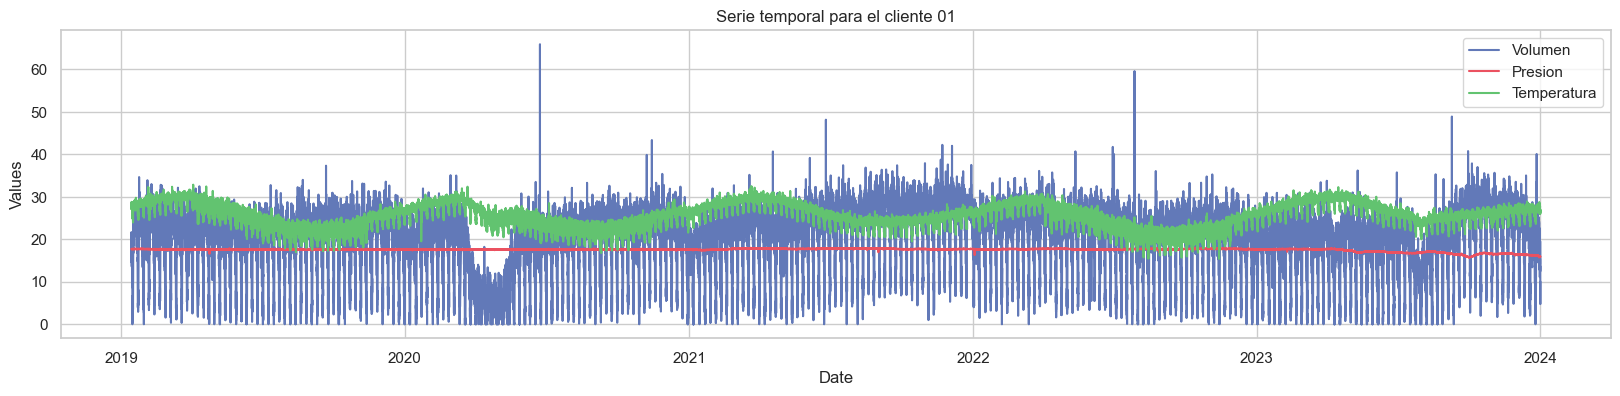

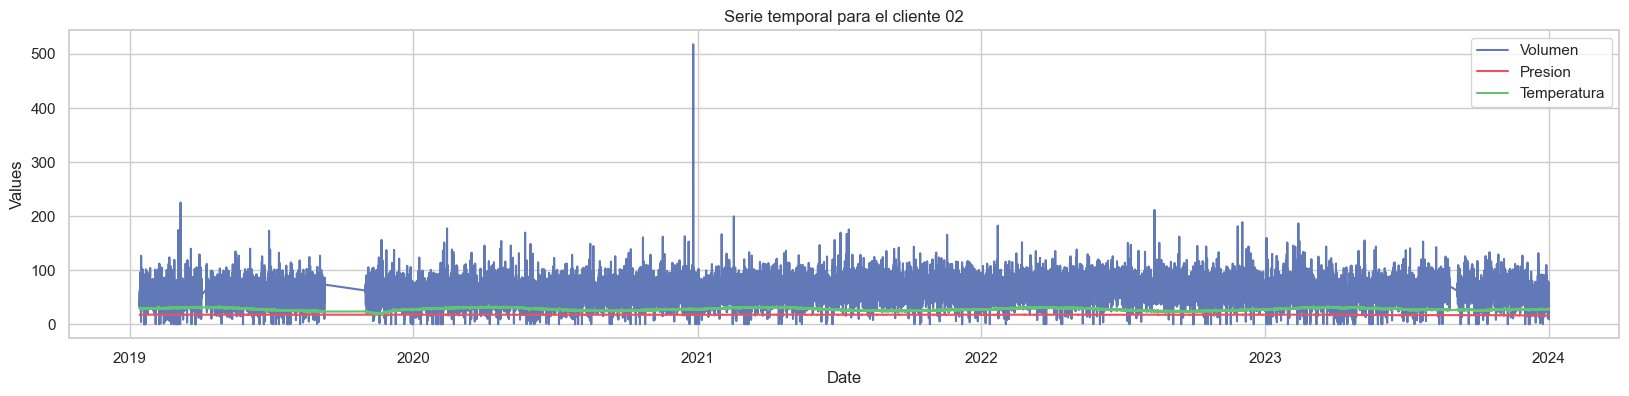

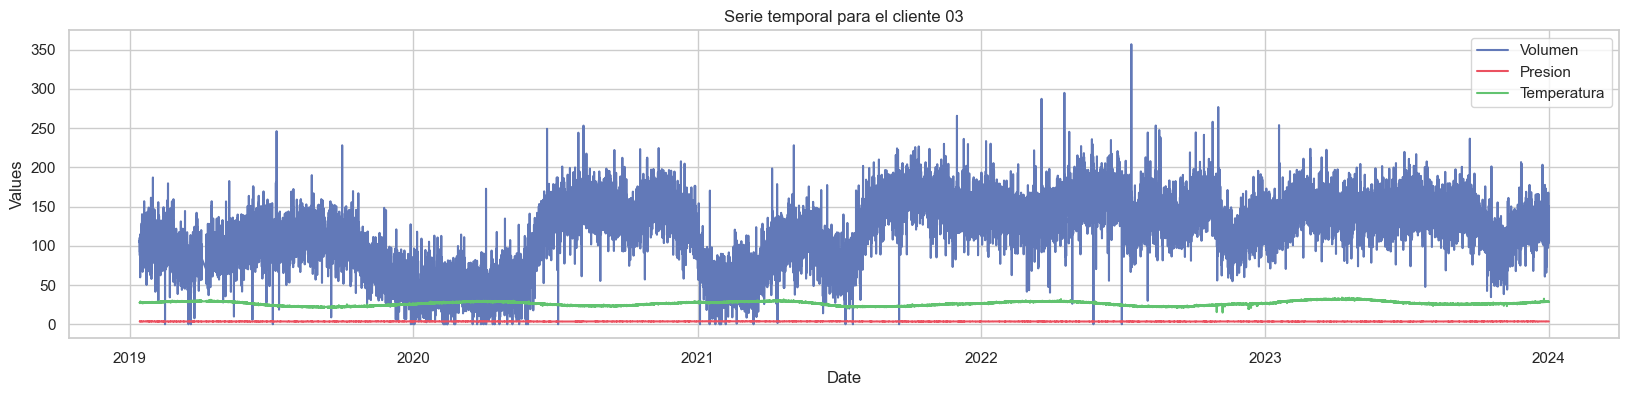

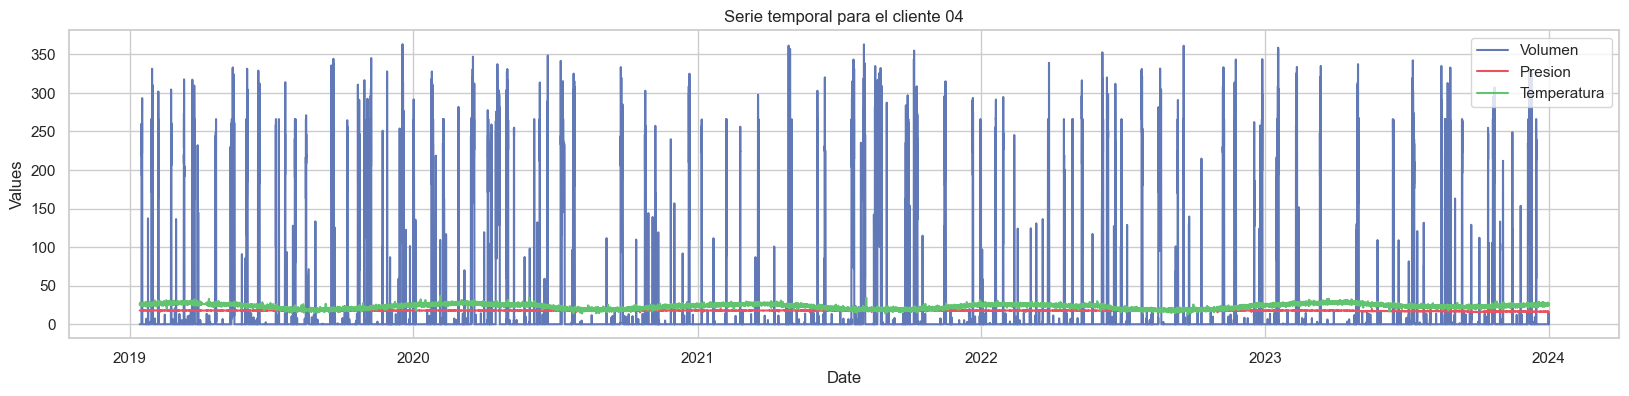

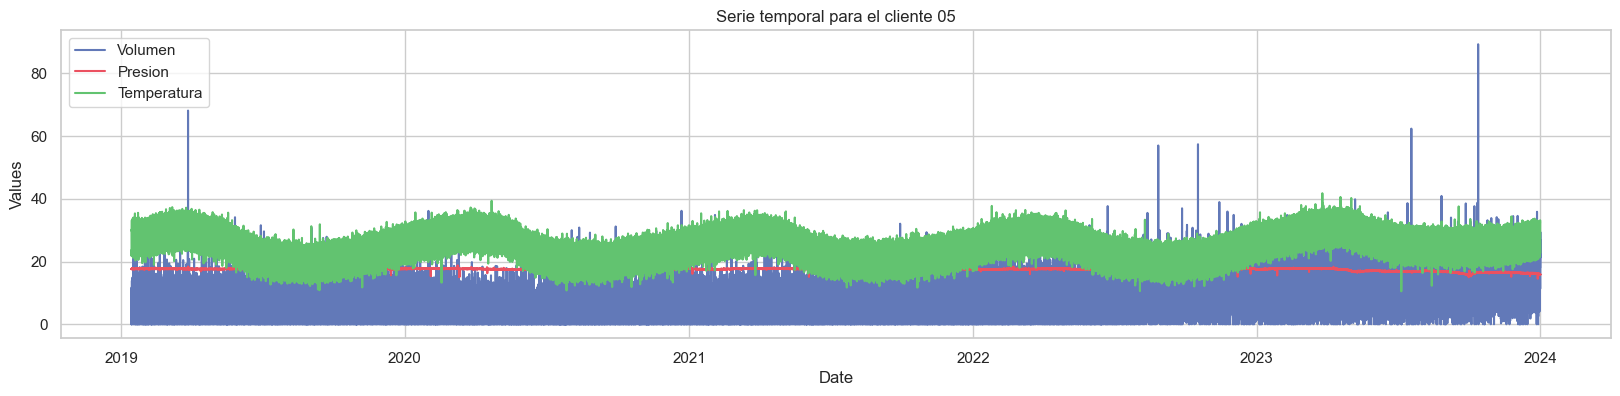

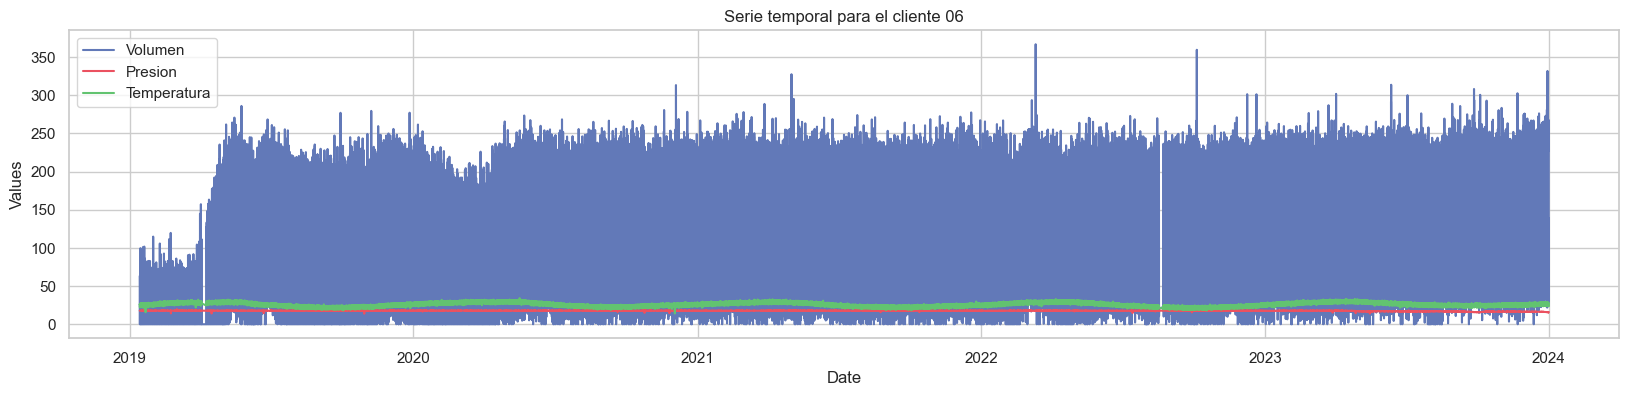

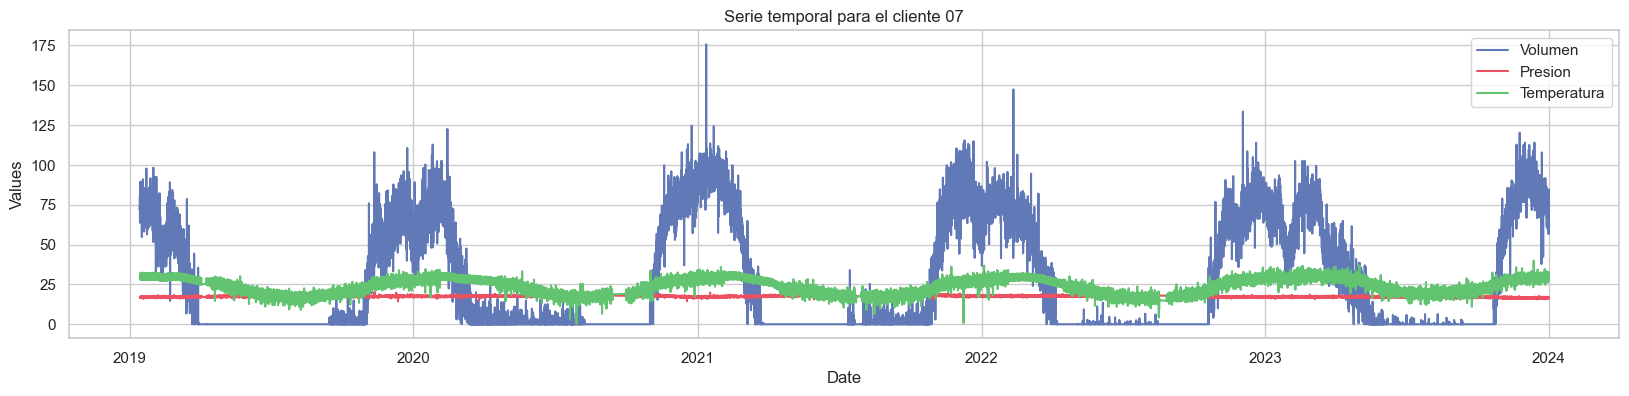

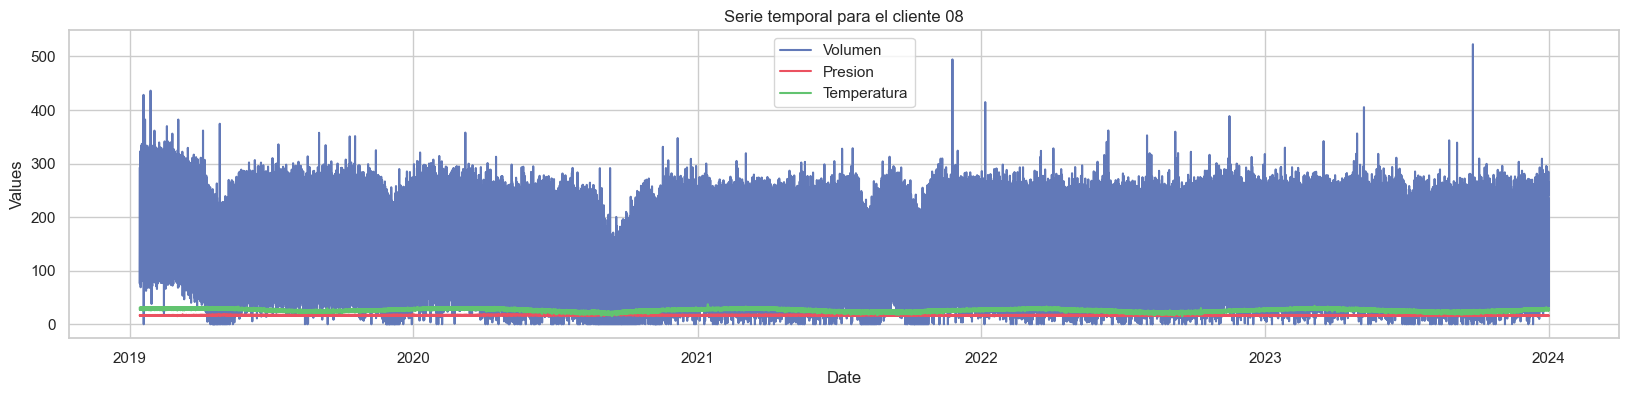

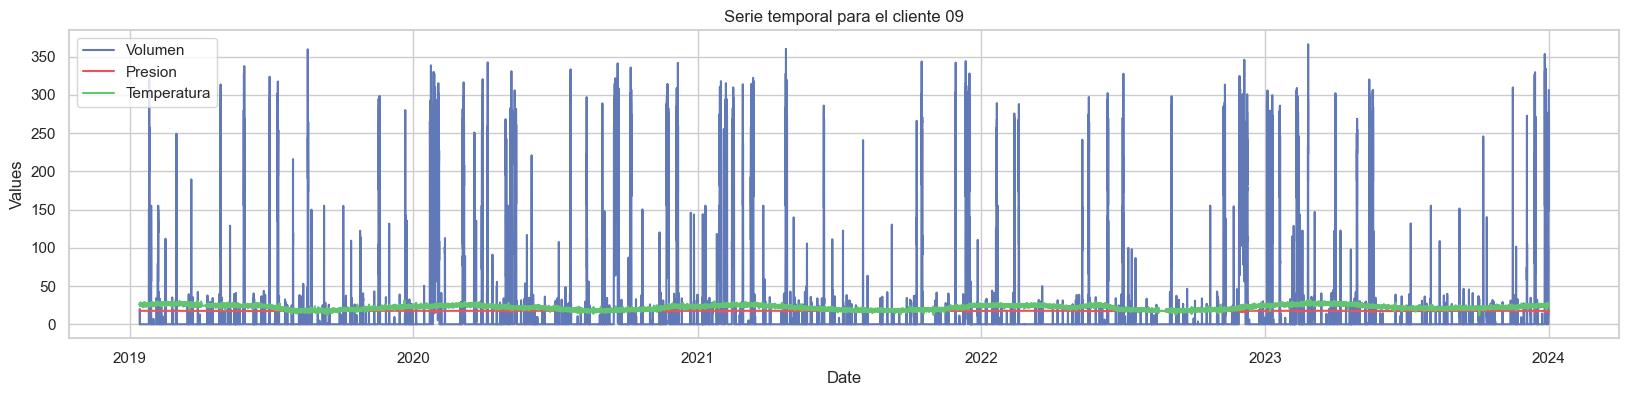

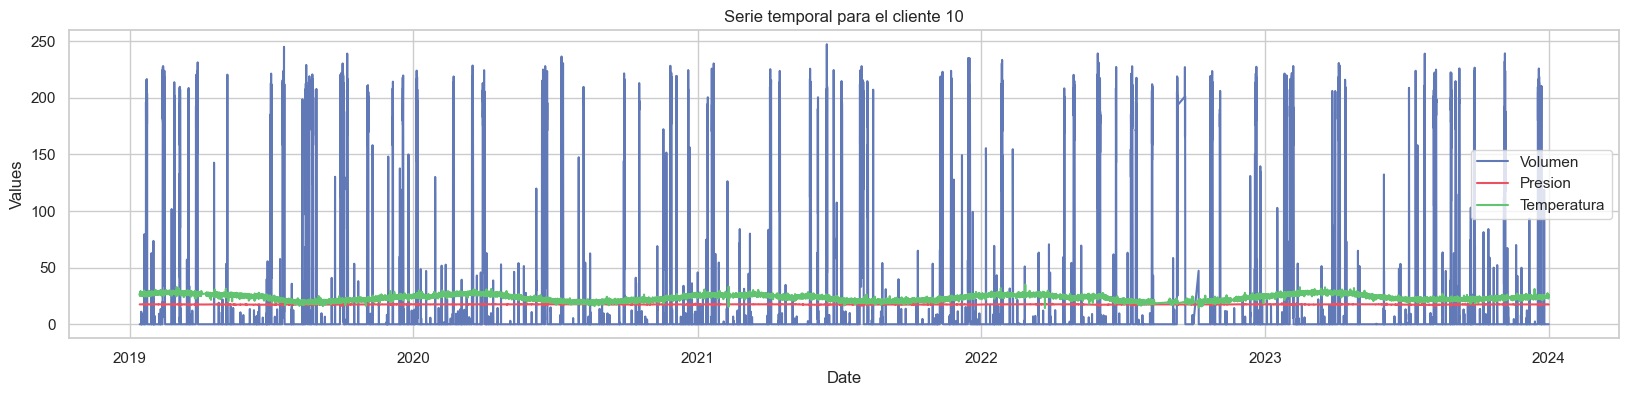

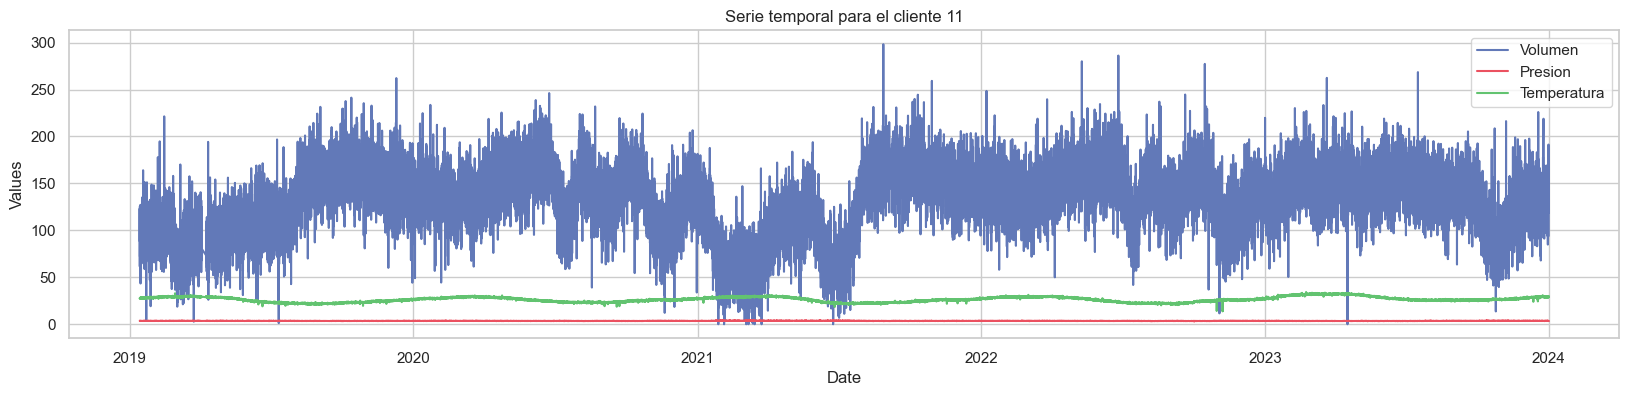

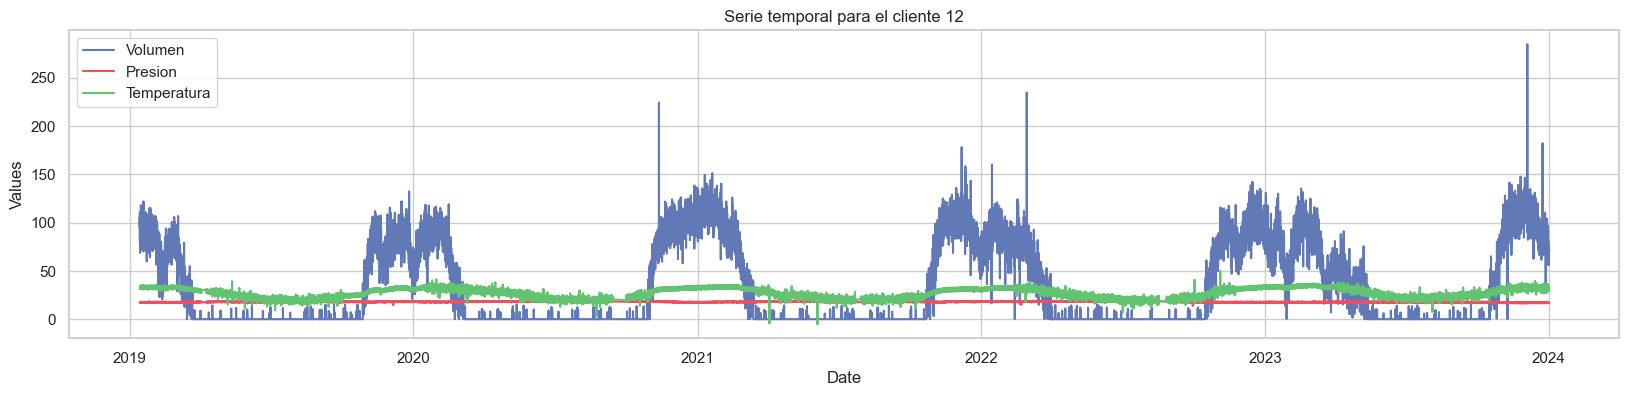

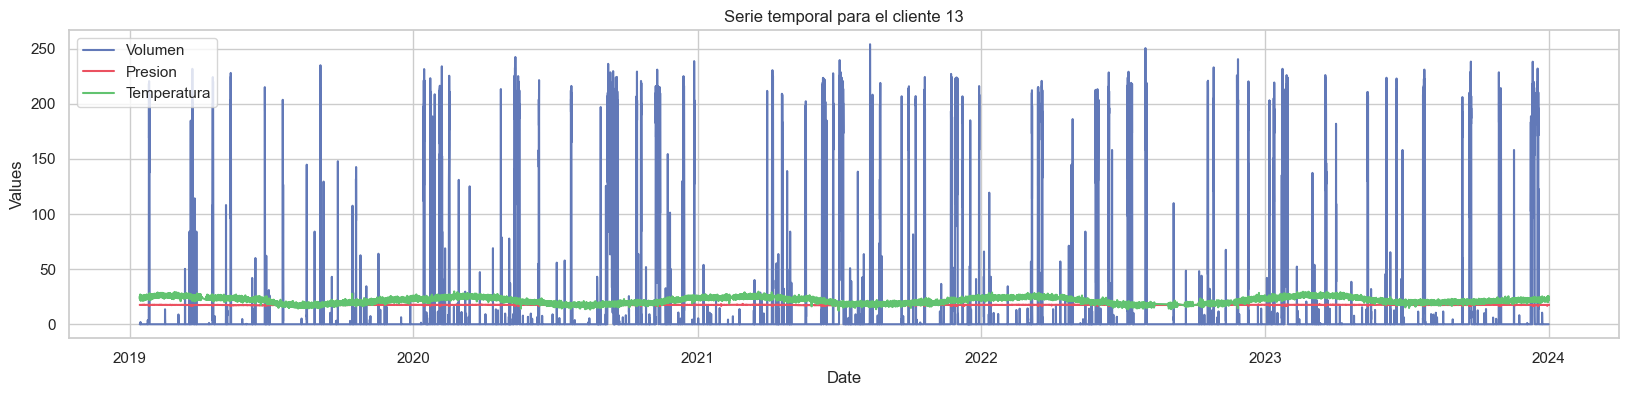

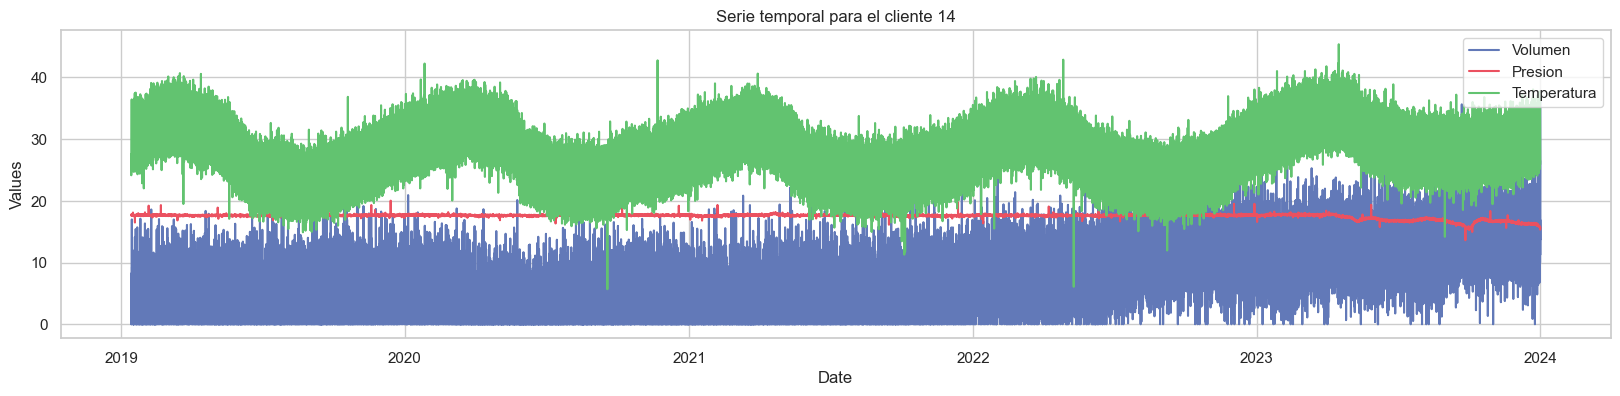

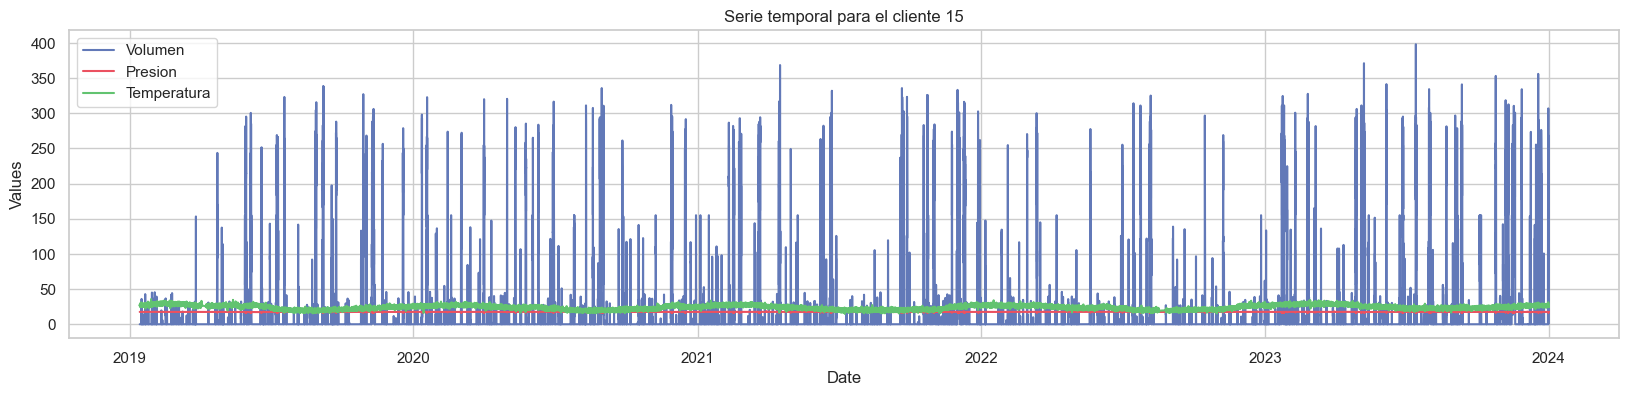

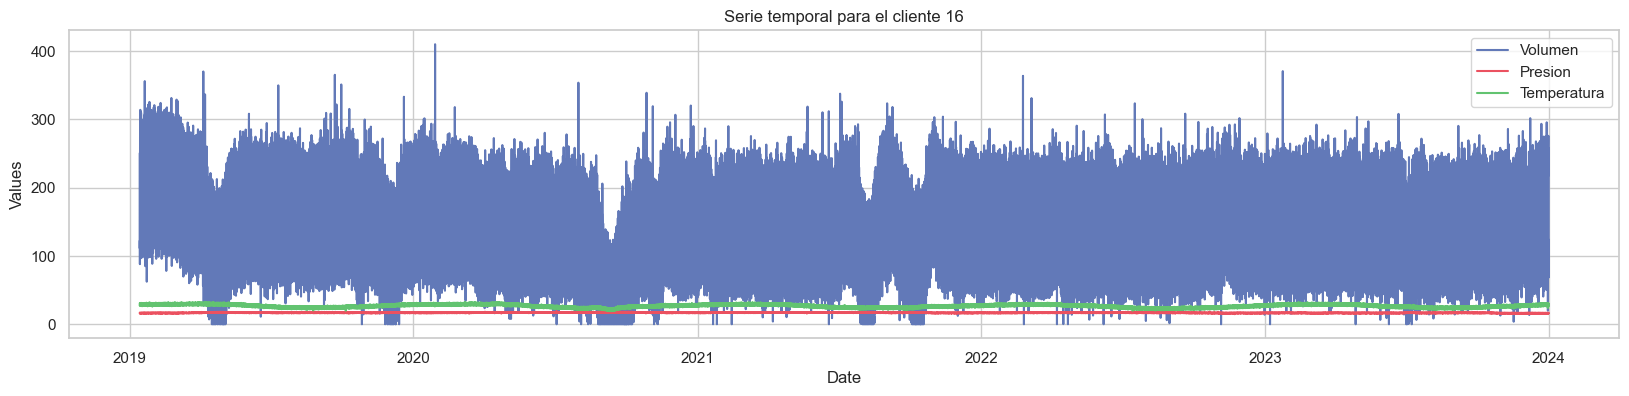

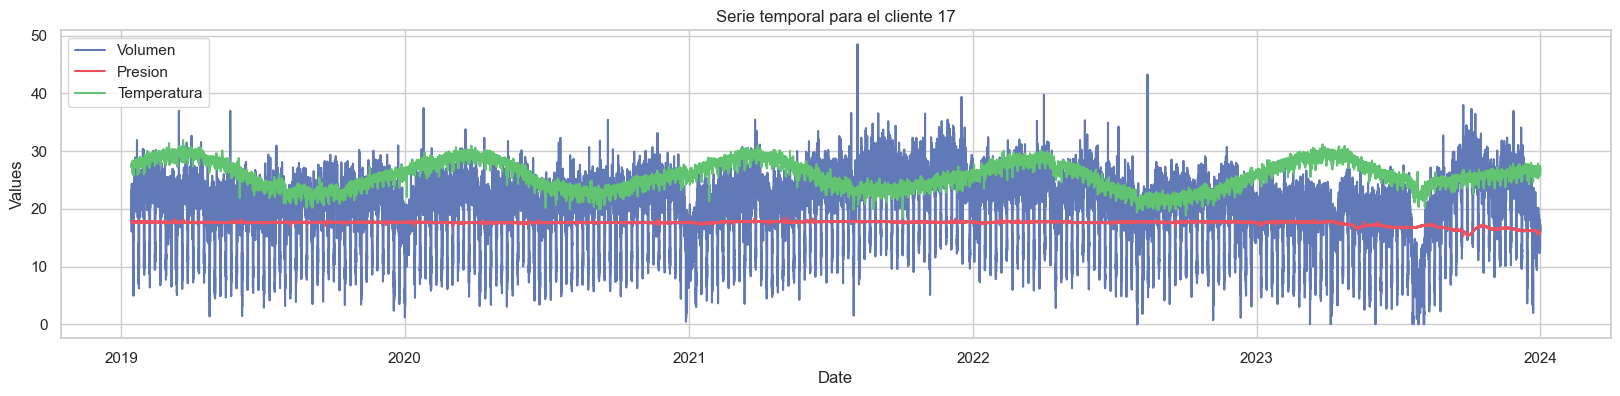

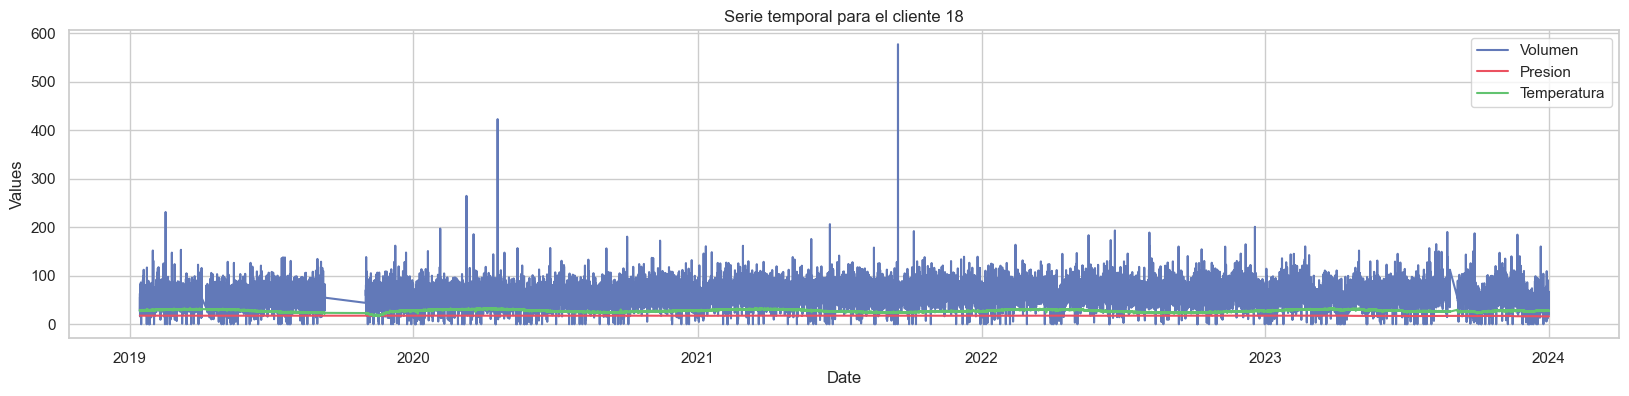

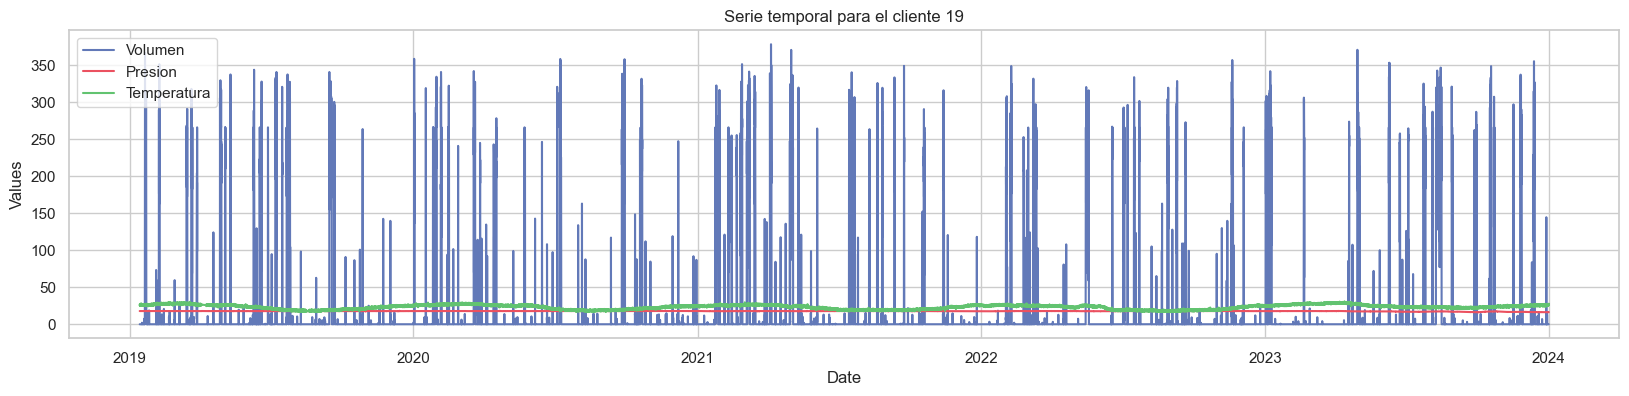

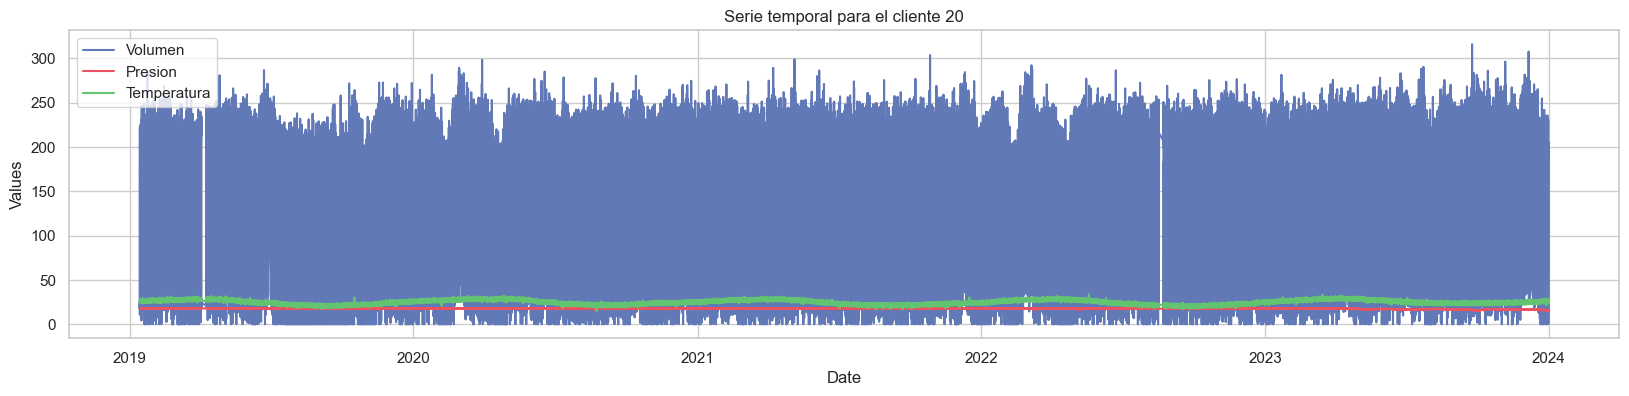

In [181]:

for client in df_contugas['Cliente'].unique():
    client_data = df_contugas[df_contugas['Cliente'] == client]
    
    plt.figure(figsize=(20, 4))
    plt.plot(client_data['Fecha'], client_data['Volumen'], label='Volumen',color='#6279B8')
    plt.plot(client_data['Fecha'], client_data['Presion'], label='Presion',color='#EB5160')
    plt.plot(client_data['Fecha'], client_data['Temperatura'], label='Temperatura',color='#62C370')
    plt.title(f'Serie temporal para el cliente {client}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()


In [185]:
# Filtrar registros con Volumen mayor a 0
df_consumo_activo = df_ceros[df_ceros["Volumen"] > 0]

# Calcular las métricas excluyendo los ceros
promedio_consumo_sin_ceros = df_consumo_activo.groupby("Cliente")["Volumen"].mean()
mediana_consumo_sin_ceros = df_consumo_activo.groupby("Cliente")["Volumen"].median()
std_consumo_sin_ceros = df_consumo_activo.groupby("Cliente")["Volumen"].std()
max_consumo_sin_ceros = df_consumo_activo.groupby("Cliente")["Volumen"].max()
min_consumo_sin_ceros = df_consumo_activo.groupby("Cliente")["Volumen"].min()

# Crear un DataFrame con las métricas resultantes
consumo_sin_ceros = pd.DataFrame({
    "Promedio_Sin_Ceros": promedio_consumo_sin_ceros,
    "Mediana_Sin_Ceros": mediana_consumo_sin_ceros,
    "Std_Sin_Ceros": std_consumo_sin_ceros,
    "Max_Sin_Ceros": max_consumo_sin_ceros,
    "Min_Sin_Ceros": min_consumo_sin_ceros
}).reset_index()

# Mostrar resultados
display(consumo_sin_ceros)


Cliente  Promedio_Sin_Ceros  Mediana_Sin_Ceros  Std_Sin_Ceros  \
0       01           20.273543          22.568829       7.626598   
1       02           62.221256          62.464027      16.817934   
2       03          117.763652         125.798876      39.602165   
3       04           59.195917           0.018082     100.829296   
4       05            9.445137           8.648625       5.853122   
5       06          160.526855         200.323271      80.118899   
6       07           56.963788          63.529528      26.554994   
7       08          182.284735         222.584528      88.080311   
8       09          101.451830          38.114859     102.523971   
9       10           94.300668          66.534370      88.349587   
10      11          131.732187         136.271239      34.177765   
11      12           75.094373          81.523237      28.429733   
12      13           68.854924           7.581418      85.303654   
13      14            8.090095           7.447396       4.922960   
14      15           95.054676          36.650720      96.403505   
15      16          179.797559         211.298174      72.976274   
16      17           20.599778          21.762590       5.509681   
17      18           61.742416          61.656692      17.687251   
18      19           71.698332           0.021071     109.340175   
19      20          165.217741         203.199388      79.315733   

    Max_Sin_Ceros  Min_Sin_Ceros  
0       65.936644   1.961638e-03  
1      517.564868   2.020595e-04  
2      356.724008   1.622638e-01  
3      363.009776   9.804226e-07  
4       89.245051   1.430555e-04  
5      366.656382   2.033072e-02  
6      175.763858   1.996175e-03  
7      522.780891   3.089021e-02  
8      366.016120   6.585445e-07  
9      247.072990   1.436340e-05  
10     298.259573   7.062679e-01  
11     284.475087   2.560381e-02  
12     253.867916   5.528296e-06  
13      36.793150   5.789806e-06  
14     398.042027   7.923668e-06  
15     409.872212   7.456039e-02  
16      48.504833   6.515987e-02  
17     577.413425   6.088063e-02  
18     378.267803   3.737014e-06  
19     315.884153   1.037903e-03

## 3. OTROS

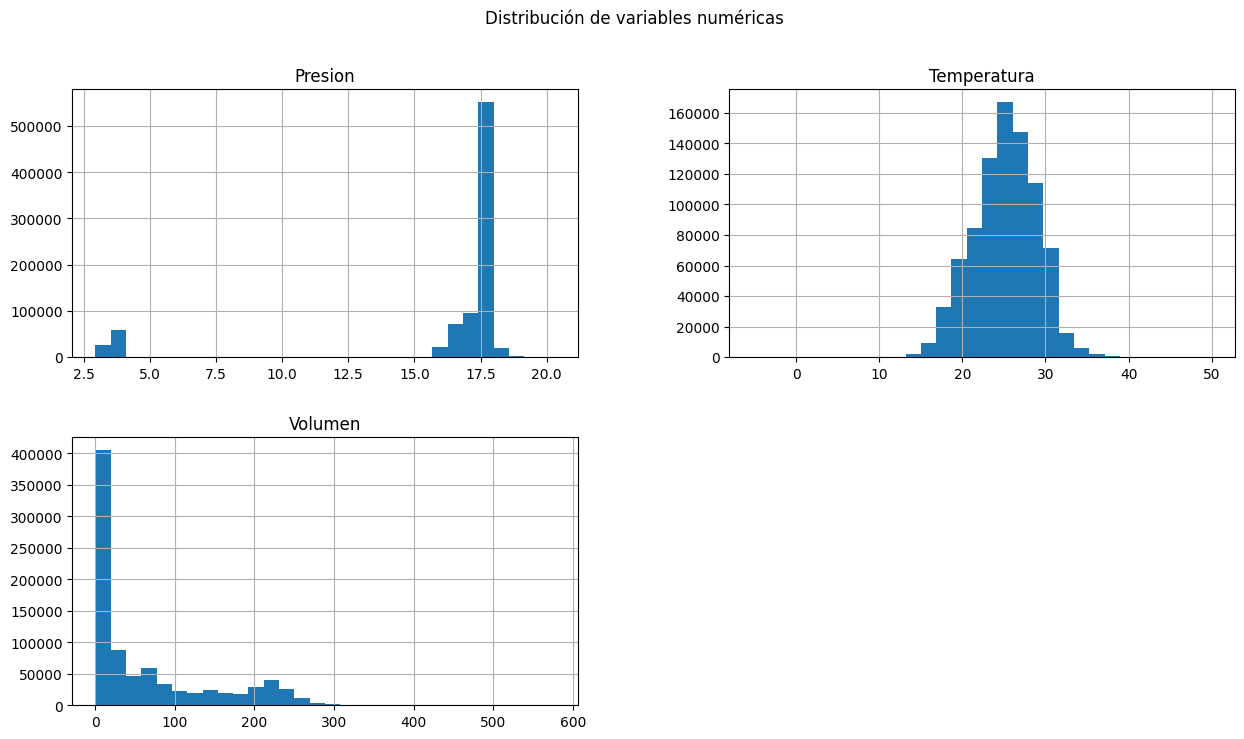

In [12]:
num_cols = ['Presion', 'Temperatura', 'Volumen']
df[num_cols].hist(bins=30, figsize=(15, 8))
plt.suptitle('Distribución de variables numéricas')
plt.show()

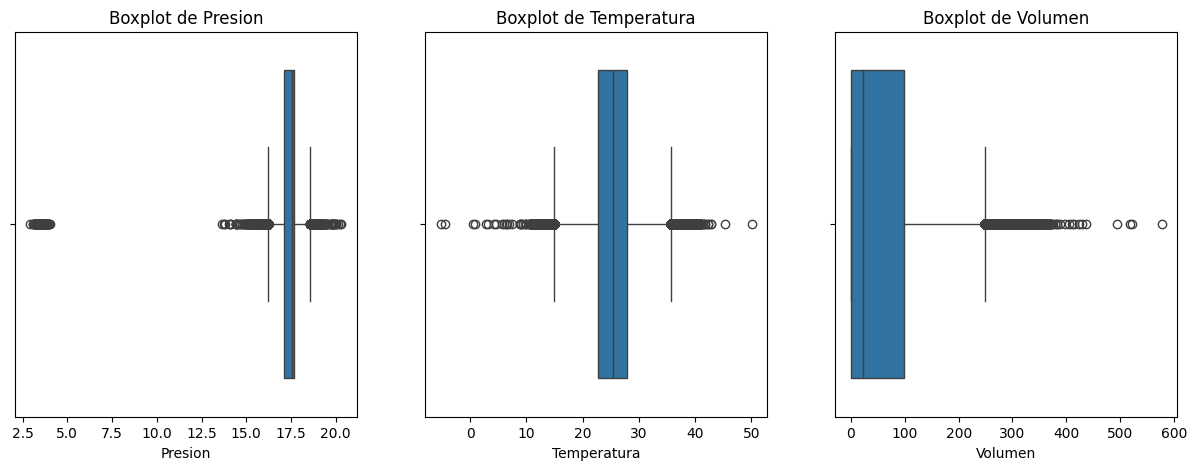

In [13]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot de {col}')
plt.show()